# Loan Approval Prediction

## Contents

- [Importing Libraries](#importing-libraries)
- [Data Understanding](#data-understanding)
- [EDA](#eda)
- [Data Preprocessing](#data-preprocessing)
- [Model Implementation](#model-implementation)
- [Hyperparameter Tuning and Reducing Overfitting](#hyperparameter-tuning-and-reducing-overfitting)
- [Appendix](#appendix)



### Dataset Source : 
https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data

### About the dataset :
This dataset is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

## Importing Libraries

In [4]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Data Handling
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV, GridSearchCV

# Model Evaluation
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    roc_curve
)
from sklearn.utils import resample

# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # also used for feature selection
from xgboost import XGBClassifier
import lightgbm as lgb

# Resampling
from imblearn.over_sampling import SMOTE

# Hyperparameter Tuning test
from scipy.stats import randint

# Miscellaneous
from collections import Counter
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')


## Data Understanding

In [5]:
# Importing the dataset
dataset = pd.read_csv('/Users/suriakumarkaruppannan/Library/CloudStorage/OneDrive-Personal/Applied Machine Learning/Assignment/loan_data.csv')

In [6]:
dataset.head()

person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561   
1                 0.08                         2.0           504   
2                 0.44                         3.0           635   
3                 0.44                         2.0           675   
4                 0.53                         4.0           586   

  previous_loan_defaults_on_file  loan_status  
0                             No            1  
1                            Yes            0  
2                             No            1  
3                             No            1  
4                             No            1

In [7]:
dataset.shape

(45000, 14)

This dataset has 45000 rows and 14 columns

In [8]:
dataset.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [9]:
# convert to age to int format
dataset['person_age'] = dataset['person_age'].astype('int')
dataset['person_age'].dtypes

dtype('int64')

In [10]:
dataset.dtypes

person_age                          int64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [11]:
cat_cols = [var for var in dataset.columns if dataset[var].dtypes == 'object']
num_cols = [var for var in dataset.columns if dataset[var].dtypes != 'object']

print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


In [12]:
dataset.isnull().sum() # Finding for missing values

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [13]:
duplicates = dataset[dataset.duplicated()]
print(duplicates)


Empty DataFrame
Columns: [person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_defaults_on_file, loan_status]
Index: []


In [14]:
dataset.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  45000.000000   4.500000e+04    45000.000000  45000.000000   
mean      27.764178   8.031905e+04        5.410333   9583.157556   
std        6.045108   8.042250e+04        6.063532   6314.886691   
min       20.000000   8.000000e+03        0.000000    500.000000   
25%       24.000000   4.720400e+04        1.000000   5000.000000   
50%       26.000000   6.704800e+04        4.000000   8000.000000   
75%       30.000000   9.578925e+04        8.000000  12237.250000   
max      144.000000   7.200766e+06      125.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   45000.000000         45000.000000                45000.000000   
mean       11.006606             0.139725                    5.867489   
std         2.978808             0.087212                    3.879702   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.660000                   30.000000   

       credit_score   loan_status  
count  45000.000000  45000.000000  
mean     632.608756      0.222222  
std       50.435865      0.415744  
min      390.000000      0.000000  
25%      601.000000      0.000000  
50%      640.000000      0.000000  
75%      670.000000      0.000000  
max      850.000000      1.000000

#### Observations:
1. person_age:

* Min = 20, Max = 144 (144 is unusually high for age, likely an outlier).

2. person_income:

* Min = 8,000, Max = 7,200,766 (extremely high compared to the 75th percentile).

3. person_emp_exp:

* Min = 0, Max = 125 (125 years of experience is unrealistic). Values above a certain threshold (e.g., retirement age) may be outliers.

4. loan_amnt:

* Min = 500, Max = 35,000 (appears reasonable).

5. loan_int_rate:

* Range: 5.42 to 20.00 (no apparent anomalies based on interest rates).

7. cb_person_cred_hist_length:

* Min = 2, Max = 30 , which is reasonable

8. credit_score:

* Min = 390, Max = 850 (within a typical credit score range; unlikely to have outliers).

9. loan_status:
* Target Variable is imbalanced, will use SMOTE Technique towards data spiltting


## EDA

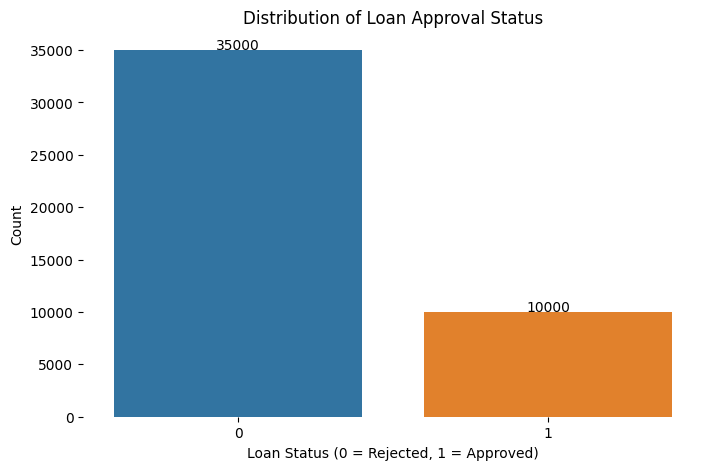

In [15]:
loan_status_counts = dataset['loan_status'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts, palette='tab10')

plt.title('Distribution of Loan Approval Status')
plt.xlabel('Loan Status (0 = Rejected, 1 = Approved)')
plt.ylabel('Count')

for index, value in enumerate(loan_status_counts):
    plt.text(index, value + 50, f'{value}', ha='center')

sns.despine(left=True, bottom=True)
plt.show()

Target variable is imbalanced, this will be countered towards feature selection

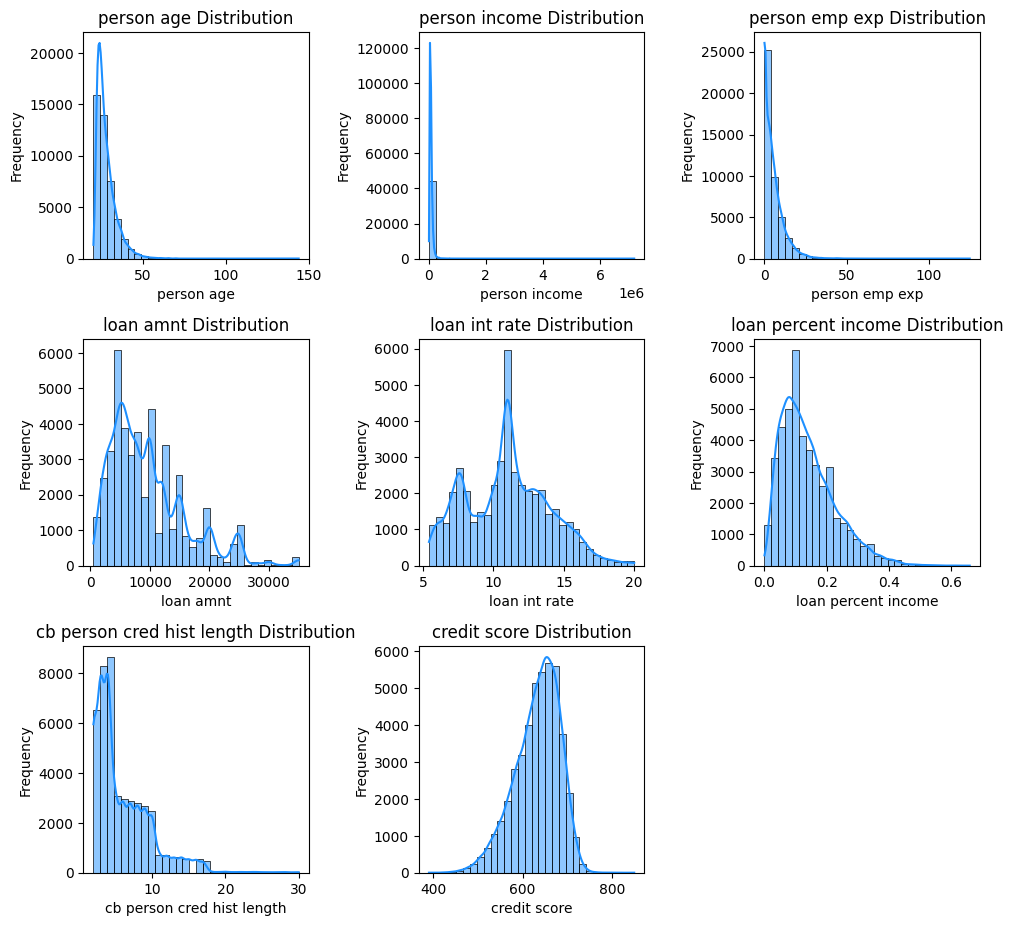

In [16]:
def univariate_analysis(data, columns):
    plt.figure(figsize=(10, 12))

    for i, column in enumerate(columns, 1):
        plt.subplot(4, 3, i)
        sns.histplot(data[column], kde=True, bins=30, color='dodgerblue')
        plt.title(f'{column.replace("_", " ")} Distribution')
        plt.xlabel(column.replace('_', ' '))
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

columns_to_analyze = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

univariate_analysis(dataset, columns_to_analyze)

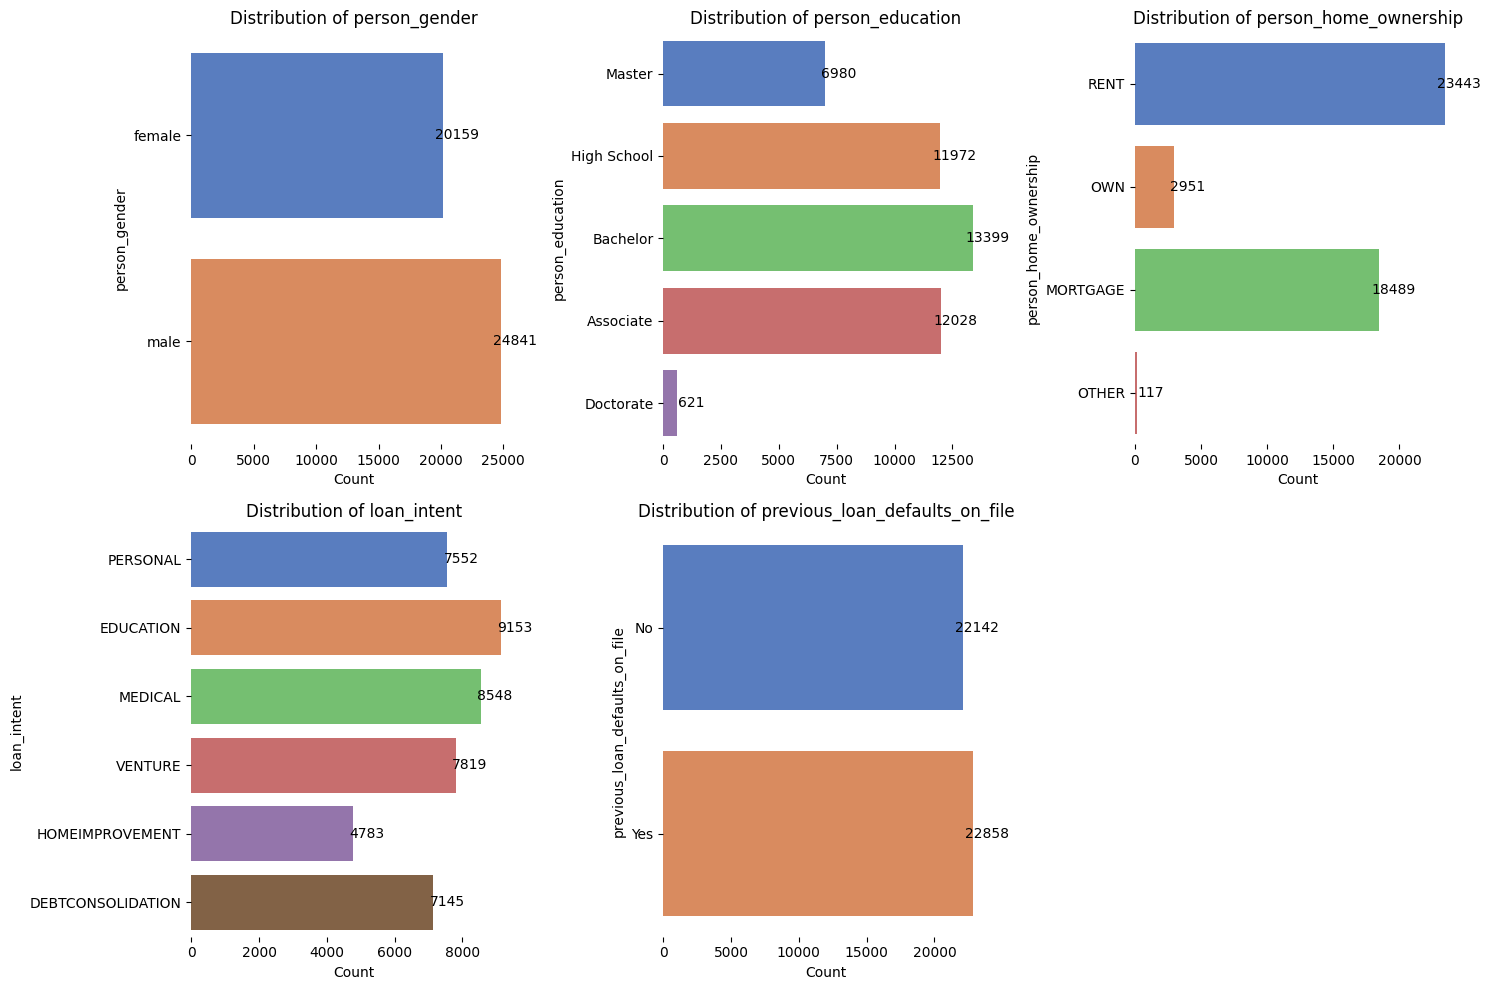

In [17]:
def plot_all_categorical_distributions_in_one(data):
    # Identify categorical columns
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    num_columns = len(categorical_columns)

    fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(15, 5 * ((num_columns // 3) + 1)))
    axes = axes.flatten()  

    for i, column in enumerate(categorical_columns):
        sns.countplot(y=column, data=data, palette='muted', ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(column)

        for p in axes[i].patches:
            axes[i].annotate(f'{int(p.get_width())}', 
                             (p.get_width(), p.get_y() + p.get_height() / 2),
                             ha='center', va='center', 
                             xytext=(10, 0), textcoords='offset points')

        sns.despine(left=True, bottom=True, ax=axes[i])
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_categorical_distributions_in_one(dataset)


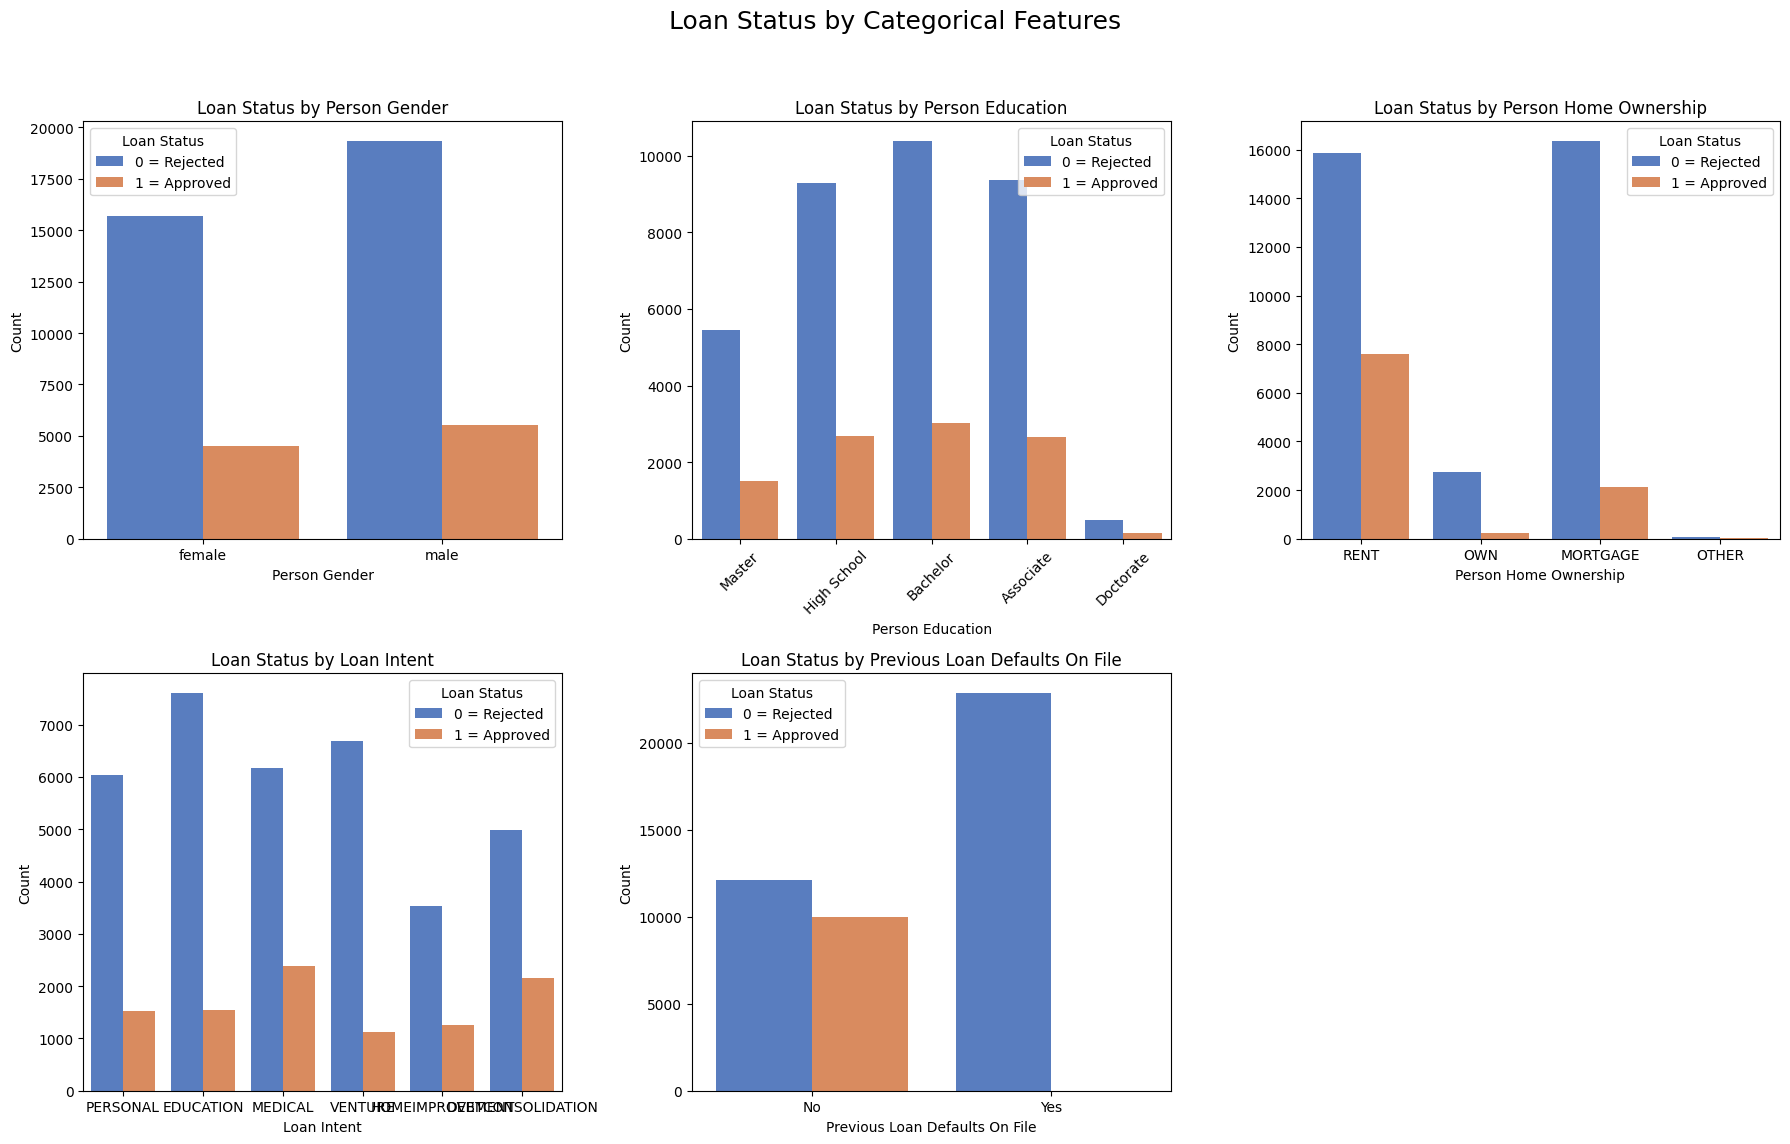

In [18]:
categorical_features = [
    'person_gender', 
    'person_education', 
    'person_home_ownership', 
    'loan_intent', 
    'previous_loan_defaults_on_file'
]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Loan Status by Categorical Features", fontsize=18)

for i, feature in enumerate(categorical_features):
    row, col = divmod(i, 3)
    sns.countplot(data=dataset, x=feature, hue='loan_status', ax=axes[row, col], palette='muted')
    axes[row, col].set_title(f"Loan Status by {feature.replace('_', ' ').title()}")
    axes[row, col].set_xlabel(feature.replace('_', ' ').title())
    axes[row, col].set_ylabel("Count")
    axes[row, col].legend(title='Loan Status', labels=['0 = Rejected', '1 = Approved'])
    if feature == 'person_education':  # Rotate ticks for clarity if needed
        axes[row, col].tick_params(axis='x', rotation=45)

if len(categorical_features) < 6:
    fig.delaxes(axes[1, 2])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


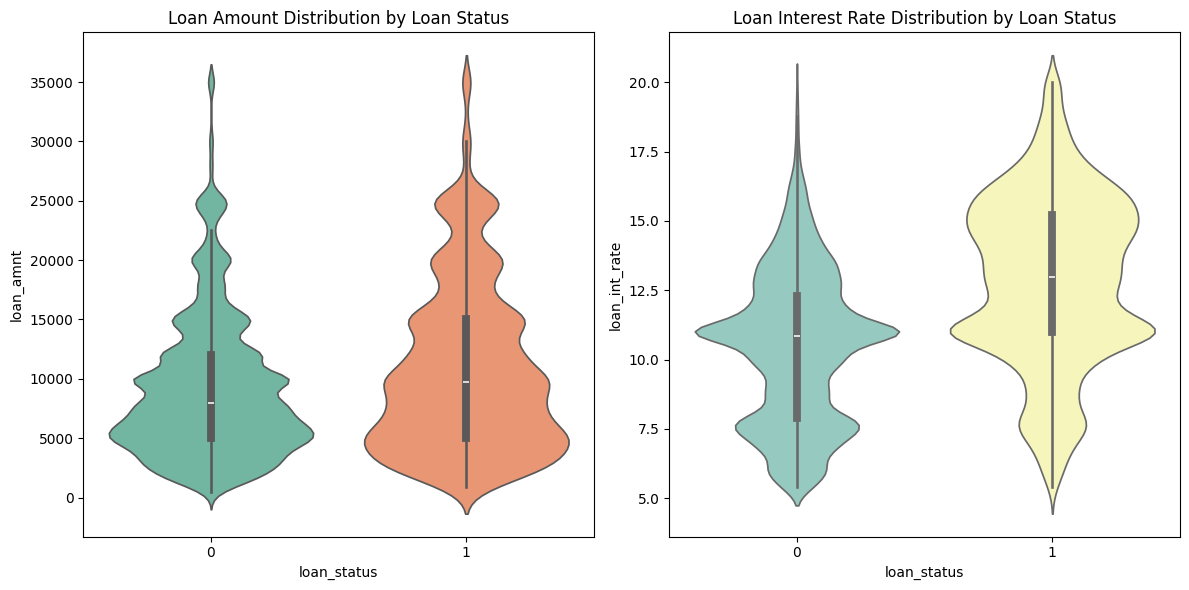

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x='loan_status', y='loan_amnt', data=dataset, palette='Set2')  # Set2 palette
plt.title('Loan Amount Distribution by Loan Status')
plt.subplot(1, 2, 2)
sns.violinplot(x='loan_status', y='loan_int_rate', data=dataset, palette='Set3')  # Set3 palette
plt.title('Loan Interest Rate Distribution by Loan Status')
plt.tight_layout()
plt.show()


Insights for loan amount and loan interest rate by loan status:

Loan Amount Distribution by Loan Status:

The distribution of loan amounts differs between approved and rejected loans.
Approved loans show a broader spread across different loan amounts, with a central tendency around mid-range amounts.
Rejected loans tend to cluster at both low and high loan amounts, indicating that very small or large loan requests are more likely to be rejected.
Loan Interest Rate Distribution by Loan Status:

Loan interest rates are higher for rejected loans, with a central tendency around a higher rate compared to approved loans.
Approved loans have a narrower distribution with lower average interest rates, suggesting that lower-risk (lower-interest) loans have better chances of approval.

## Data Preprocessing

#### Investigating Outliers

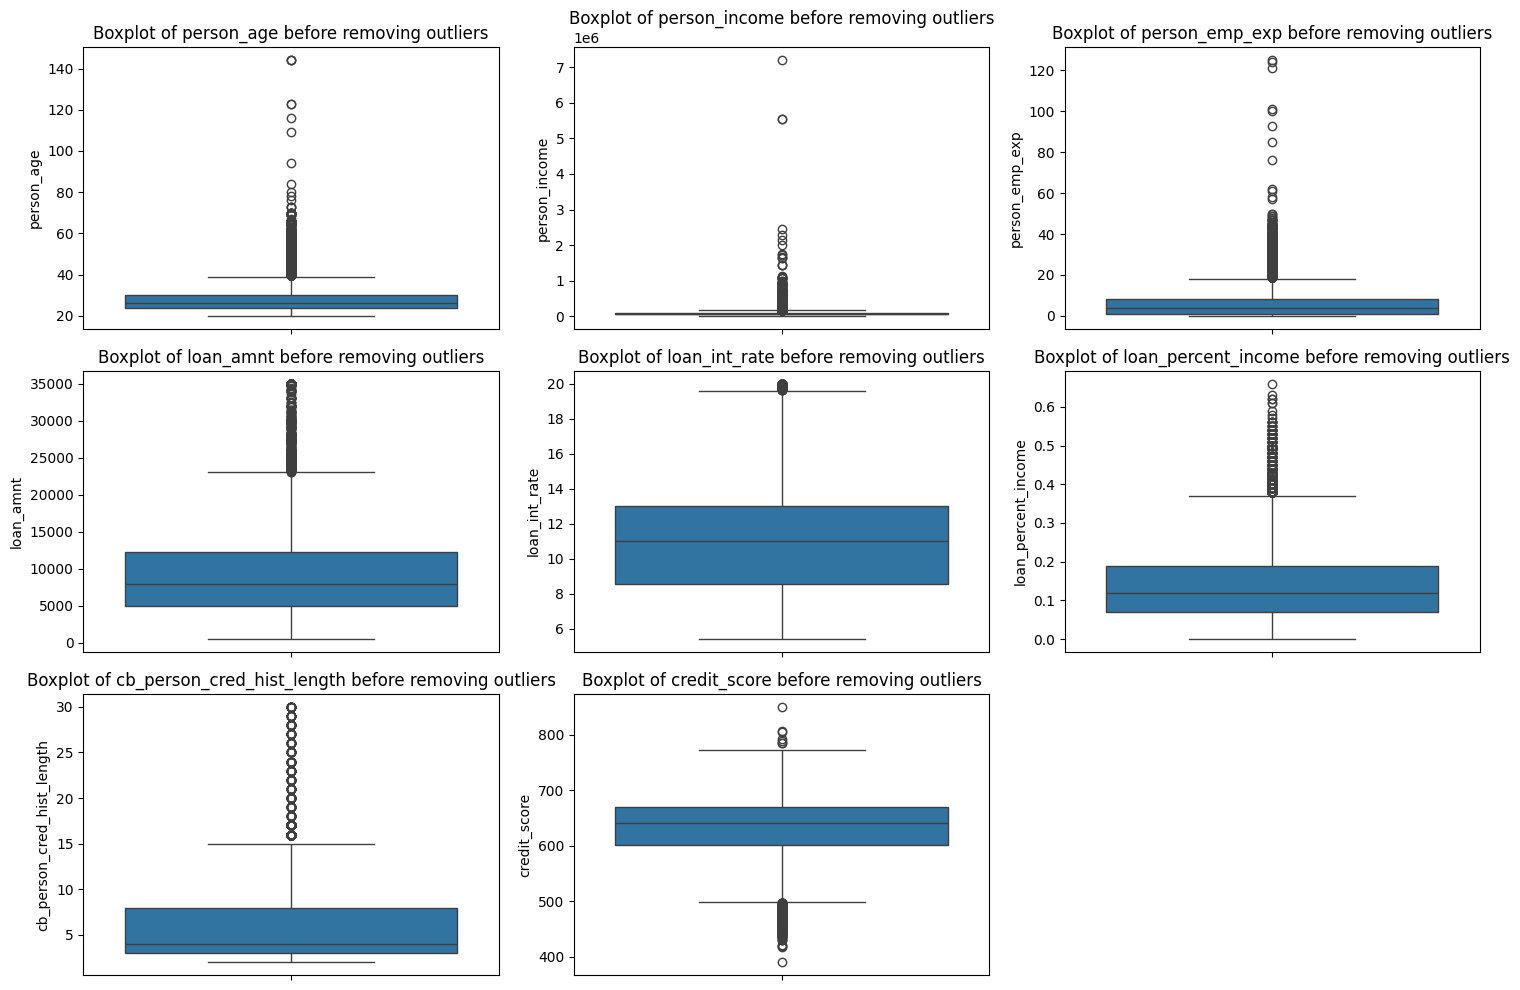

In [20]:
numerical_columns = [
    "person_age", "person_income", "person_emp_exp", "loan_amnt",
    "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"
]
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(y=dataset[col])
    plt.title(f"Boxplot of {col} before removing outliers")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

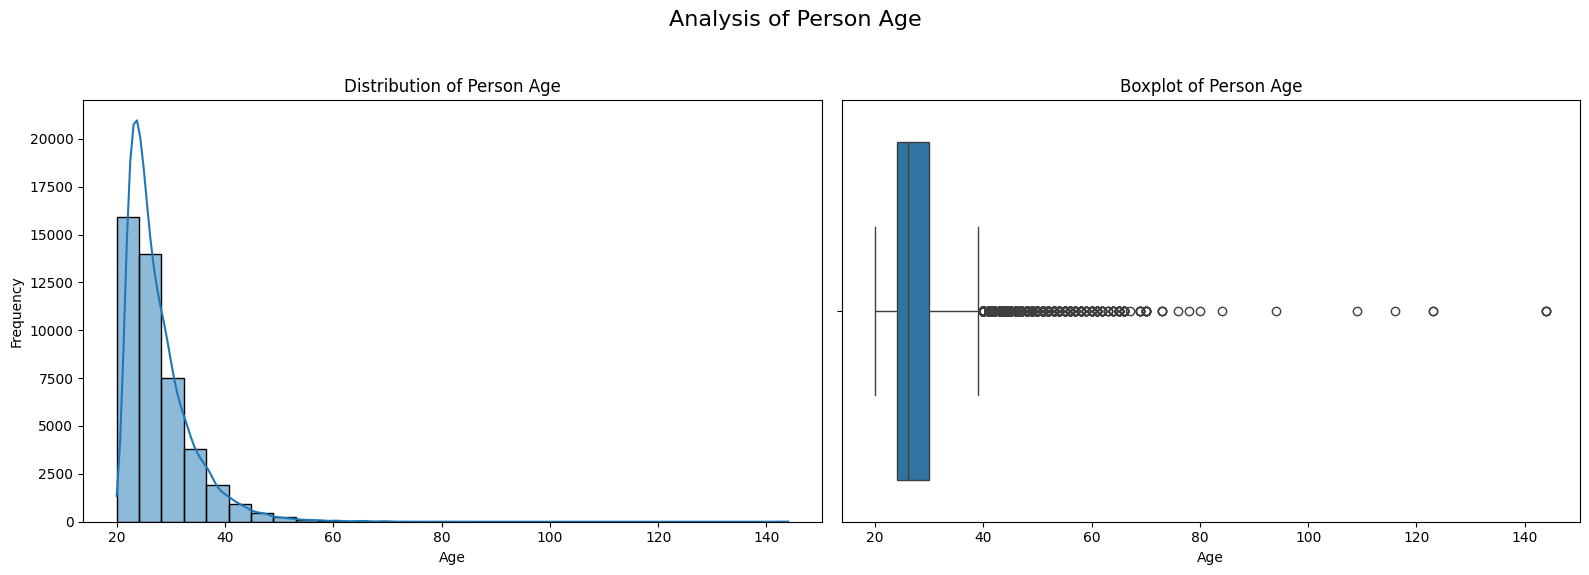

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Analysis of Person Age", fontsize=16)

sns.histplot(dataset['person_age'], kde=True, bins=30, ax=axes[0])
axes[0].set_title("Distribution of Person Age")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")
sns.boxplot(x=dataset['person_age'], ax=axes[1])
axes[1].set_title("Boxplot of Person Age")
axes[1].set_xlabel("Age")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [22]:
print(dataset['person_age'].describe())


count    45000.000000
mean        27.764178
std          6.045108
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64


In [23]:
# Remove rows where person_age is greater than 55
dataset = dataset[dataset['person_age'] <= 55]
print(dataset['person_age'].describe())

count    44843.000000
mean        27.634413
std          5.570048
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max         55.000000
Name: person_age, dtype: float64


Given the distribution of age (mean around 27 and 75th percentile at 30), it's clear that such high values are likely erroneous or outliers.

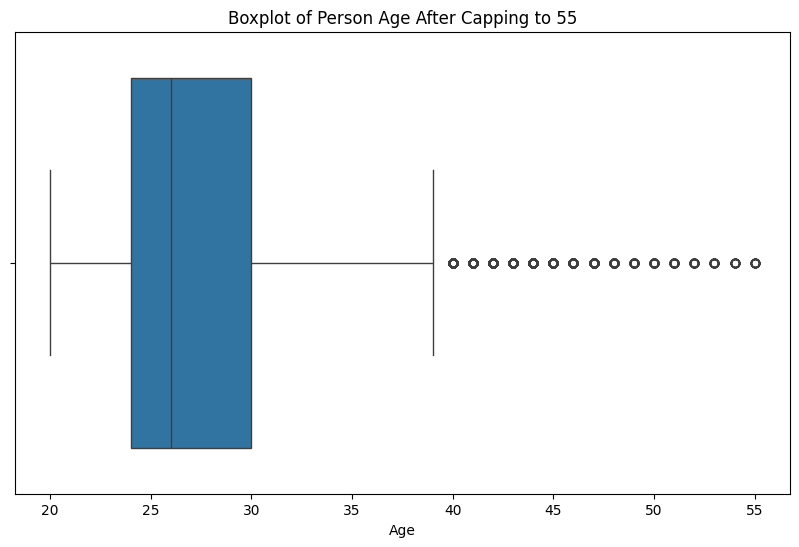

In [24]:
# Replot the boxplot after capping the age
plt.figure(figsize=(10,6))
sns.boxplot(x=dataset['person_age'])
plt.title("Boxplot of Person Age After Capping to 55")
plt.xlabel("Age")
plt.show()


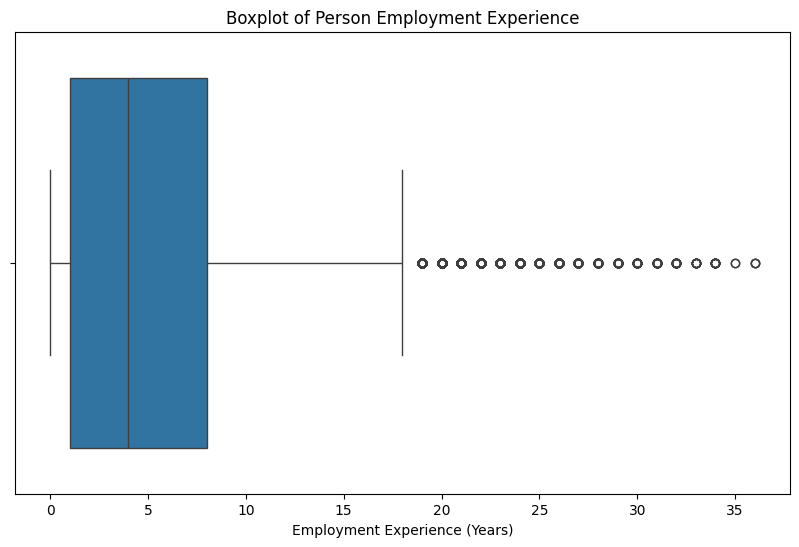

In [25]:
# Check the distribution of 'person_emp_exp'
dataset['person_emp_exp'].describe()

plt.figure(figsize=(10,6))
sns.boxplot(x=dataset['person_emp_exp'])
plt.title("Boxplot of Person Employment Experience")
plt.xlabel("Employment Experience (Years)")
plt.show()


In [26]:
print(dataset['person_emp_exp'].describe())

count    44843.000000
mean         5.280378
std          5.584888
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max         36.000000
Name: person_emp_exp, dtype: float64


In [27]:
def handle_outliers_iqr(dataset, column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers
    dataset[column] = np.where(dataset[column] < lower_bound, lower_bound, dataset[column])
    dataset[column] = np.where(dataset[column] > upper_bound, upper_bound, dataset[column])
    return dataset
numerical_columns = [
    "person_income", "loan_percent_income"
]

for col in numerical_columns:
    dataset = handle_outliers_iqr(dataset, col)

In [28]:
dataset['person_emp_exp'] = np.where(dataset['person_emp_exp'] > 30, 30, dataset['person_emp_exp'])


In [29]:
dataset.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  44843.000000   44843.000000    44843.000000  44843.000000   
mean      27.634413   75630.362699        5.276320   9580.180920   
std        5.570048   38025.650768        5.565756   6310.233837   
min       20.000000    8000.000000        0.000000    500.000000   
25%       24.000000   47161.500000        1.000000   5000.000000   
50%       26.000000   67043.000000        4.000000   8000.000000   
75%       30.000000   95721.500000        8.000000  12230.000000   
max       55.000000  168561.500000       30.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   44843.000000         44843.000000                44843.000000   
mean       11.006299             0.138865                    5.807060   
std         2.978909             0.084329                    3.738881   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.370000                   30.000000   

       credit_score   loan_status  
count  44843.000000  44843.000000  
mean     632.411391      0.222197  
std       50.322015      0.415728  
min      390.000000      0.000000  
25%      601.000000      0.000000  
50%      639.000000      0.000000  
75%      669.000000      0.000000  
max      768.000000      1.000000

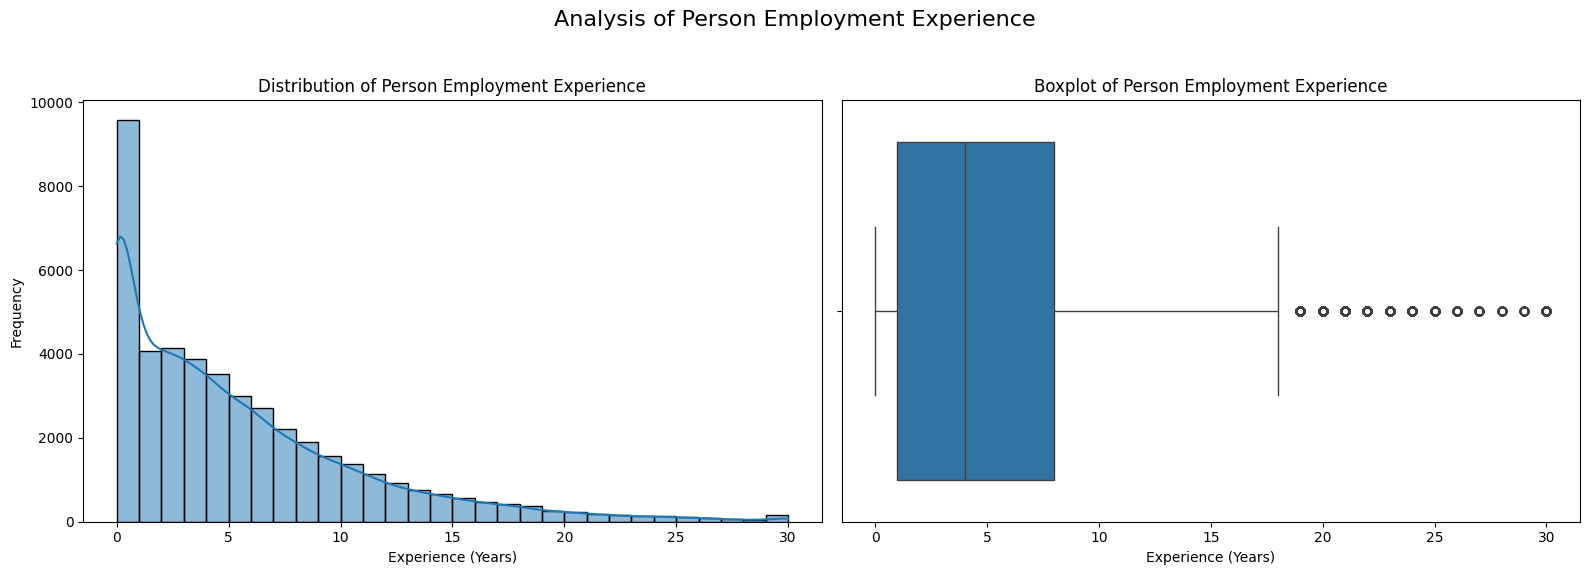

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Analysis of Person Employment Experience", fontsize=16)

sns.histplot(dataset['person_emp_exp'], kde=True, bins=30, ax=axes[0])
axes[0].set_title("Distribution of Person Employment Experience")
axes[0].set_xlabel("Experience (Years)")
axes[0].set_ylabel("Frequency")

sns.boxplot(x=dataset['person_emp_exp'], ax=axes[1])
axes[1].set_title("Boxplot of Person Employment Experience")
axes[1].set_xlabel("Experience (Years)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [31]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = dataset['person_emp_exp'].quantile(0.25)
Q3 = dataset['person_emp_exp'].quantile(0.75)

# Display quartiles
print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
# Calculate IQR
IQR = Q3 - Q1
print(f"IQR (Interquartile Range): {IQR}")


Q1 (25th percentile): 1.0
Q3 (75th percentile): 8.0
IQR (Interquartile Range): 7.0


In [32]:
# Calculate lower and upper bounds
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Display bounds
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")


Lower Bound: -9.5
Upper Bound: 18.5


Any value of person_emp_exp less than -9.5 is considered an outlier.
Any value greater than 18.5 is considered an outlier.
Since person_emp_exp represents experience (likely in years), a negative value isn't meaningful. Therefore:

Values below 0 can already be treated as invalid.
The upper bound (18.5) identifies higher experience values as potential outliers

In [33]:
# Identify outliers
outliers = dataset[(dataset['person_emp_exp'] < lower_bound) | (dataset['person_emp_exp'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")
print("Outliers:")
print(outliers)


Number of outliers: 1567
Outliers:
       person_age person_gender person_education  person_income  \
29120          40        female         Bachelor       168561.5   
29121          50          male      High School       168561.5   
29124          45          male           Master        96924.0   
29127          44          male      High School       168561.5   
29131          43        female           Master       168561.5   
...           ...           ...              ...            ...   
44916          42        female      High School       100310.0   
44923          47          male        Associate        46637.0   
44947          42          male        Doctorate       168561.5   
44972          43          male        Associate       168561.5   
44977          43          male        Associate        22639.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
29120              19              MORTGAGE    10000.0            MEDICAL   
29121 

In [34]:
# Remove outliers
dataset = dataset[(dataset['person_emp_exp'] >= lower_bound) & (dataset['person_emp_exp'] <= upper_bound)]

# Display cleaned data summary
print(f"Cleaned data size: {len(dataset)}")


Cleaned data size: 43276


In [35]:
dataset.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  43276.000000   43276.000000    43276.000000  43276.000000   
mean      27.011669   75388.637259        4.639292   9563.656923   
std        4.523709   37883.589505        4.481106   6301.319886   
min       20.000000    8000.000000        0.000000    500.000000   
25%       24.000000   47014.500000        1.000000   5000.000000   
50%       26.000000   66978.500000        3.000000   8000.000000   
75%       30.000000   94988.250000        7.000000  12184.500000   
max       45.000000  168561.500000       18.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   43276.000000         43276.000000                43276.000000   
mean       11.003866             0.139132                    5.470353   
std         2.977286             0.084398                    3.270543   
min         5.420000             0.000000                    2.000000   
25%         8.590000             0.070000                    3.000000   
50%        11.010000             0.120000                    4.000000   
75%        12.990000             0.190000                    8.000000   
max        20.000000             0.370000                   20.000000   

       credit_score   loan_status  
count  43276.000000  43276.000000  
mean     631.529855      0.222641  
std       50.112366      0.416024  
min      390.000000      0.000000  
25%      600.000000      0.000000  
50%      639.000000      0.000000  
75%      669.000000      0.000000  
max      768.000000      1.000000

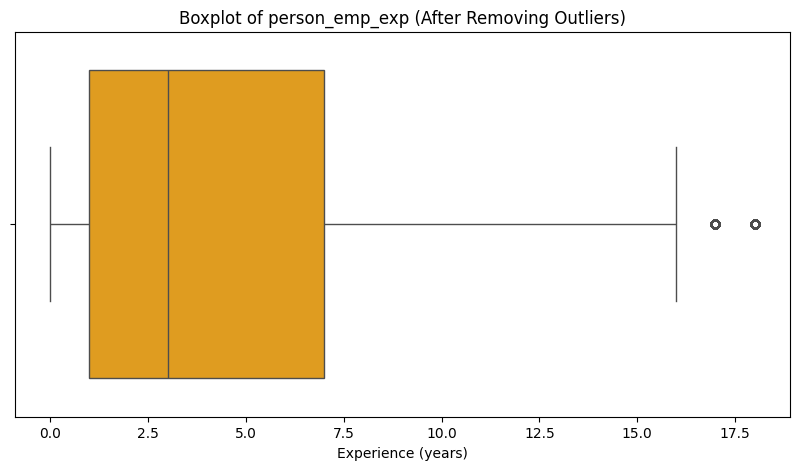

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=dataset['person_emp_exp'], color='orange')
plt.title('Boxplot of person_emp_exp (After Removing Outliers)')
plt.xlabel('Experience (years)')
plt.show()


In [37]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = dataset['person_income'].quantile(0.25)
Q3 = dataset['person_income'].quantile(0.75)

# Display quartiles
print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
# Calculate IQR
IQR = Q3 - Q1
print(f"IQR (Interquartile Range): {IQR}")

Q1 (25th percentile): 47014.5
Q3 (75th percentile): 94988.25
IQR (Interquartile Range): 47973.75


In [38]:
# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display bounds
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Lower Bound: -24946.125
Upper Bound: 166948.875


In [39]:
# Identify outliers
outliers = dataset[(dataset['person_income'] < lower_bound) | (dataset['person_income'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")
print("Outliers:")
print(outliers)

Number of outliers: 2075
Outliers:
       person_age person_gender person_education  person_income  \
15             23        female           Master       168561.5   
20             25          male         Bachelor       168561.5   
33             25        female      High School       168561.5   
34             26        female        Associate       168561.5   
42             26          male         Bachelor       168561.5   
...           ...           ...              ...            ...   
44615          34          male      High School       168561.5   
44786          27          male        Associate       168561.5   
44831          25        female      High School       168561.5   
44836          26          male        Doctorate       168561.5   
44922          29          male           Master       168561.5   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
15                  5              MORTGAGE    30000.0  DEBTCONSOLIDATION   
20    

In [40]:
# Remove outliers
dataset = dataset[(dataset['person_income'] >= lower_bound) & (dataset['person_income'] <= upper_bound)]

# Display cleaned data summary
print(f"Cleaned data size: {len(dataset)}")

Cleaned data size: 41201


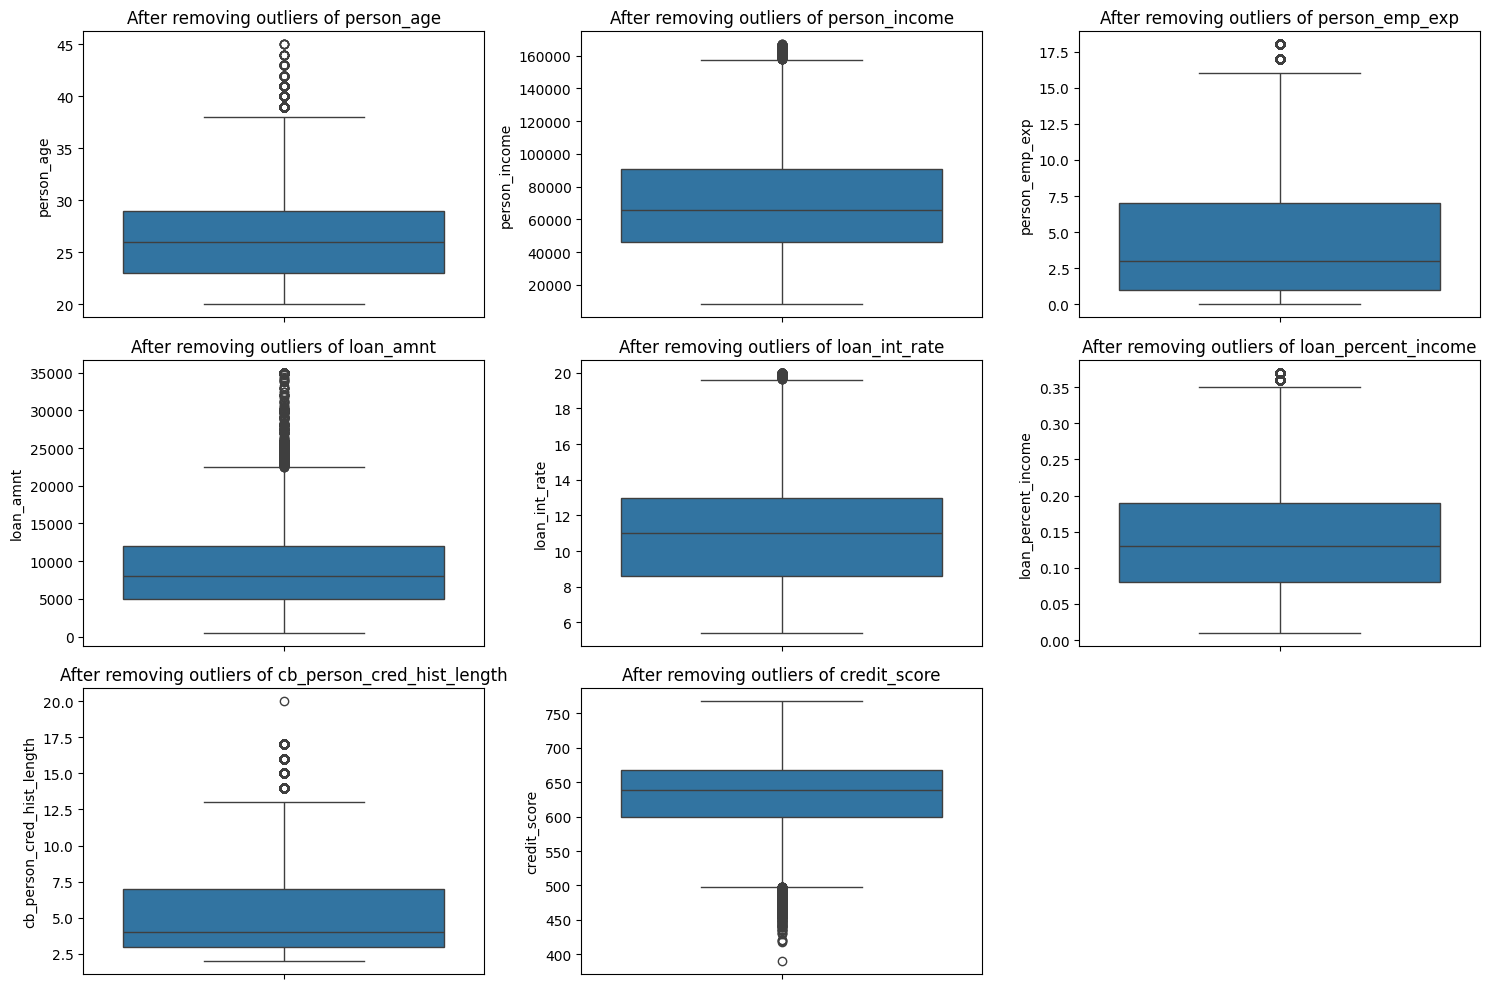

In [41]:
numerical_columns = [
    "person_age", "person_income", "person_emp_exp", "loan_amnt",
    "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length", "credit_score"
]
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(y=dataset[col])
    plt.title(f"After removing outliers of {col}")
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [42]:
dataset.describe()

person_age  person_income  person_emp_exp     loan_amnt  \
count  41201.000000   41201.000000    41201.000000  41201.000000   
mean      26.902575   70696.441640        4.538701   9262.303148   
std        4.492196   32376.806095        4.444869   6030.154373   
min       20.000000    8000.000000        0.000000    500.000000   
25%       23.000000   45954.000000        1.000000   5000.000000   
50%       26.000000   65535.000000        3.000000   8000.000000   
75%       29.000000   90677.000000        7.000000  12000.000000   
max       45.000000  166935.000000       18.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   41201.000000         41201.000000                41201.000000   
mean       10.990340             0.142590                    5.400403   
std         2.973982             0.084554                    3.237206   
min         5.420000             0.010000                    2.000000   
25%         8.580000             0.080000                    3.000000   
50%        11.010000             0.130000                    4.000000   
75%        12.990000             0.190000                    7.000000   
max        20.000000             0.370000                   20.000000   

       credit_score   loan_status  
count  41201.000000  41201.000000  
mean     631.304240      0.229315  
std       50.129809      0.420397  
min      390.000000      0.000000  
25%      600.000000      0.000000  
50%      638.000000      0.000000  
75%      668.000000      0.000000  
max      768.000000      1.000000

#### Checking for negative values

In [43]:
numeric_columns = dataset.select_dtypes(include=['number'])

# Check for negative values across numeric columns
negative_values = dataset[numeric_columns.lt(0).any(axis=1)]
print(negative_values)



Empty DataFrame
Columns: [person_age, person_gender, person_education, person_income, person_emp_exp, person_home_ownership, loan_amnt, loan_intent, loan_int_rate, loan_percent_income, cb_person_cred_hist_length, credit_score, previous_loan_defaults_on_file, loan_status]
Index: []


### Data labelling / Encoding

In [44]:
label_encoder = LabelEncoder()

# Encoding person_gender (female -> 0, male -> 1)
dataset['person_gender'] = label_encoder.fit_transform(dataset['person_gender'])

# Encoding previous_loan_defaults_on_file (No -> 0, Yes -> 1)
dataset['previous_loan_defaults_on_file'] = label_encoder.fit_transform(dataset['previous_loan_defaults_on_file'])
print(dataset[['person_gender', 'previous_loan_defaults_on_file']].head())


   person_gender  previous_loan_defaults_on_file
0              0                               0
1              0                               1
2              0                               0
3              0                               0
4              1                               0


In [45]:
# Define the mapping for ordinal encoding
education_map = {
    'High School': 0,
    'Associate': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate': 4
}

# Apply ordinal encoding to person_education
dataset['person_education'] = dataset['person_education'].map(education_map)
print(dataset[['person_education']].head())


   person_education
0                 3
1                 0
2                 0
3                 2
4                 3


In [46]:
# One-Hot Encoding for person_home_ownership
dataset = pd.get_dummies(dataset, columns=['person_home_ownership', 'loan_intent'], dtype=int)


In [47]:
dataset.head()

person_age  person_gender  person_education  person_income  person_emp_exp  \
0          22              0                 3        71948.0               0   
1          21              0                 0        12282.0               0   
2          25              0                 0        12438.0               3   
3          23              0                 2        79753.0               0   
4          24              1                 3        66135.0               1   

   loan_amnt  loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0    35000.0          16.02                 0.37                         3.0   
1     1000.0          11.14                 0.08                         2.0   
2     5500.0          12.87                 0.37                         3.0   
3    35000.0          15.23                 0.37                         2.0   
4    35000.0          14.27                 0.37                         4.0   

   credit_score  ...  person_home_ownership_MORTGAGE  \
0           561  ...                               0   
1           504  ...                               0   
2           635  ...                               1   
3           675  ...                               0   
4           586  ...                               0   

   person_home_ownership_OTHER  person_home_ownership_OWN  \
0                            0                          0   
1                            0                          1   
2                            0                          0   
3                            0                          0   
4                            0                          0   

   person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
0                           1                              0   
1                           0                              0   
2                           0                              0   
3                           1                              0   
4                           1                              0   

   loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  \
0                      0                            0                    0   
1                      1                            0                    0   
2                      0                            0                    1   
3                      0                            0                    1   
4                      0                            0                    1   

   loan_intent_PERSONAL  loan_intent_VENTURE  
0                     1                    0  
1                     0                    0  
2                     0                    0  
3                     0                    0  
4                     0                    0  

[5 rows x 22 columns]

In [48]:
dataset.dtypes

person_age                          int64
person_gender                       int64
person_education                    int64
person_income                     float64
person_emp_exp                      int64
loan_amnt                         float64
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file      int64
loan_status                         int64
person_home_ownership_MORTGAGE      int64
person_home_ownership_OTHER         int64
person_home_ownership_OWN           int64
person_home_ownership_RENT          int64
loan_intent_DEBTCONSOLIDATION       int64
loan_intent_EDUCATION               int64
loan_intent_HOMEIMPROVEMENT         int64
loan_intent_MEDICAL                 int64
loan_intent_PERSONAL                int64
loan_intent_VENTURE                 int64
dtype: object

#### Correlation Matrix

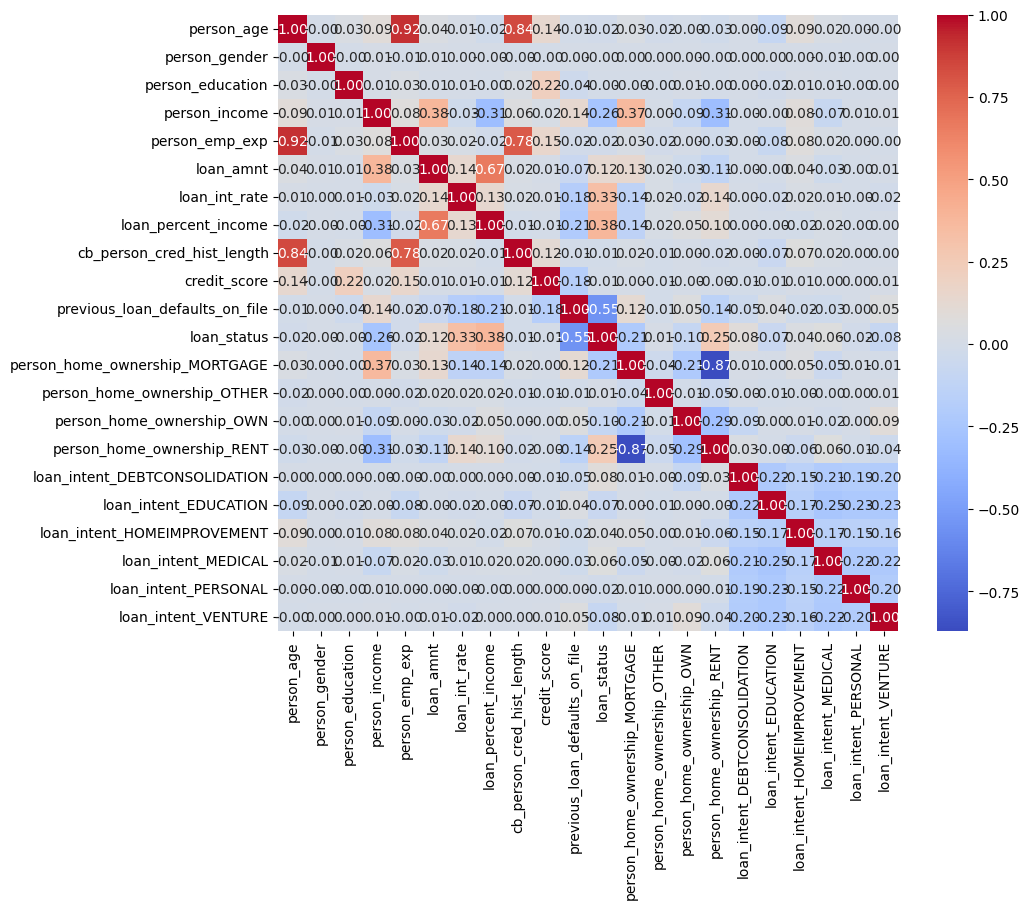

In [49]:
#Visualize correlations with a heatmap
correlation_matrix = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [50]:
correlation_matrix = dataset.corr()

# Get correlation of each feature with 'loan_status'
loan_status_corr = correlation_matrix['loan_status'].sort_values(ascending=False)
print(loan_status_corr)


loan_status                       1.000000
loan_percent_income               0.384251
loan_int_rate                     0.332863
person_home_ownership_RENT        0.254259
loan_amnt                         0.124360
loan_intent_DEBTCONSOLIDATION     0.081906
loan_intent_MEDICAL               0.060485
loan_intent_HOMEIMPROVEMENT       0.040646
person_home_ownership_OTHER       0.013488
person_gender                    -0.000430
person_education                 -0.001925
credit_score                     -0.006087
cb_person_cred_hist_length       -0.013448
loan_intent_PERSONAL             -0.017421
person_emp_exp                   -0.020362
person_age                       -0.021663
loan_intent_EDUCATION            -0.068338
loan_intent_VENTURE              -0.084427
person_home_ownership_OWN        -0.095399
person_home_ownership_MORTGAGE   -0.212439
person_income                    -0.258038
previous_loan_defaults_on_file   -0.553118
Name: loan_status, dtype: float64


Highly Correlated Variables

1. Positively Correlated (Strong Relationship):

* loan_percent_income: 0.384251 (moderate positive correlation).
* loan_int_rate: 0.332863 (moderate positive correlation).
* person_home_ownership_RENT: 0.254259 (weak positive correlation).

2. Negatively Correlated (Strong Relationship):
* previous_loan_defaults_on_file: -0.553118 (moderate-to-strong negative correlation).
* person_home_ownership_MORTGAGE: -0.212439 (weak negative correlation).
* person_income: -0.258038 (weak negative correlation).

Variables such as loan_percent_income and loan_int_rate have moderate positive correlations, suggesting individuals with higher loan percentages or interest rates are more likely to affect loan_status.
previous_loan_defaults_on_file has a strong negative correlation, indicating that defaults significantly reduce the likelihood of a positive loan outcome.
person_home_ownership_RENT positively correlates, while person_home_ownership_MORTGAGE negatively correlates, hinting at homeownership's impact on loan outcomes.

### Feature Selection

In [51]:
X = dataset.drop(columns=["loan_status"])  # Features
y = dataset["loan_status"]                # Target


### Feature Scaling

In [52]:
# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Convert scaled data back to a DataFrame for better visualization
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first 5 rows of the scaled DataFrame
print("Min-Max Scaled Data Example:")
print(X_scaled_df.head())


Min-Max Scaled Data Example:
   person_age  person_gender  person_education  person_income  person_emp_exp  \
0        0.08            0.0              0.75       0.402353        0.000000   
1        0.04            0.0              0.00       0.026942        0.000000   
2        0.20            0.0              0.00       0.027923        0.166667   
3        0.12            0.0              0.50       0.451461        0.000000   
4        0.16            1.0              0.75       0.365778        0.055556   

   loan_amnt  loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0   1.000000       0.727023             1.000000                    0.055556   
1   0.014493       0.392318             0.194444                    0.000000   
2   0.144928       0.510974             1.000000                    0.055556   
3   1.000000       0.672840             1.000000                    0.000000   
4   1.000000       0.606996             1.000000                    0.111111   

   

### Class Balancing of target variable using SMOTE-Oversampling

Original Class Distribution: Counter({0: 31753, 1: 9448})
Resampled Class Distribution: Counter({1: 31753, 0: 31753})


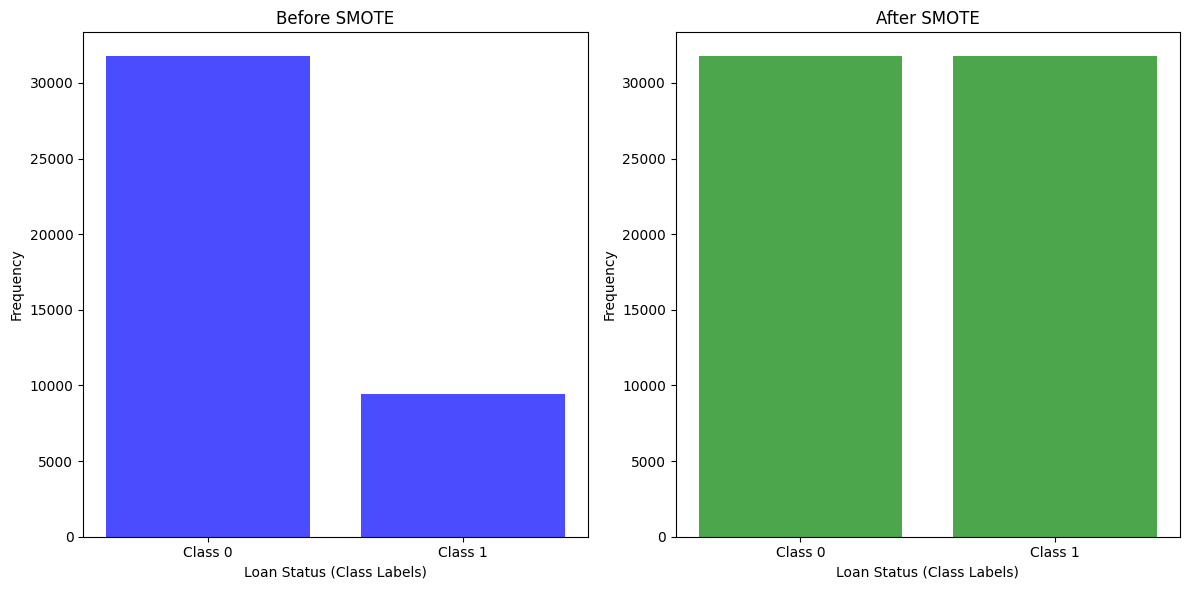

In [53]:
# Original distribution of the target variable
original_counts = Counter(y)
print("Original Class Distribution:", original_counts)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Resampled distribution of the target variable
resampled_counts = Counter(y_resampled)
print("Resampled Class Distribution:", resampled_counts)

# Visualize class distributions before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for 'Before SMOTE'
ax[0].bar(original_counts.keys(), original_counts.values(), color='blue', alpha=0.7)
ax[0].set_title('Before SMOTE')
ax[0].set_xlabel('Loan Status (Class Labels)')
ax[0].set_ylabel('Frequency')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Class 0', 'Class 1'])

# Bar chart for 'After SMOTE'
ax[1].bar(resampled_counts.keys(), resampled_counts.values(), color='green', alpha=0.7)
ax[1].set_title('After SMOTE')
ax[1].set_xlabel('Loan Status (Class Labels)')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Class 0', 'Class 1'])
plt.tight_layout()
plt.show()


In [54]:
y_resampled.value_counts()

loan_status
1    31753
0    31753
Name: count, dtype: int64

### Feature Importance/Selection

In [55]:
# Fit Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

# Extract feature importance
importances = rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances.sort_values(by="Importance", ascending=False, inplace=True)

print("Feature Importance Ranking:")
print(feature_importances)


Feature Importance Ranking:
                           Feature  Importance
10  previous_loan_defaults_on_file    0.336854
6                    loan_int_rate    0.137037
7              loan_percent_income    0.128849
3                    person_income    0.092941
5                        loan_amnt    0.050859
9                     credit_score    0.038459
14      person_home_ownership_RENT    0.034506
8       cb_person_cred_hist_length    0.033417
0                       person_age    0.031319
4                   person_emp_exp    0.028524
2                 person_education    0.017495
11  person_home_ownership_MORTGAGE    0.015788
13       person_home_ownership_OWN    0.009301
20             loan_intent_VENTURE    0.008976
17     loan_intent_HOMEIMPROVEMENT    0.006870
1                    person_gender    0.006214
15   loan_intent_DEBTCONSOLIDATION    0.005994
18             loan_intent_MEDICAL    0.005920
16           loan_intent_EDUCATION    0.005783
19            loan_intent_PERSON

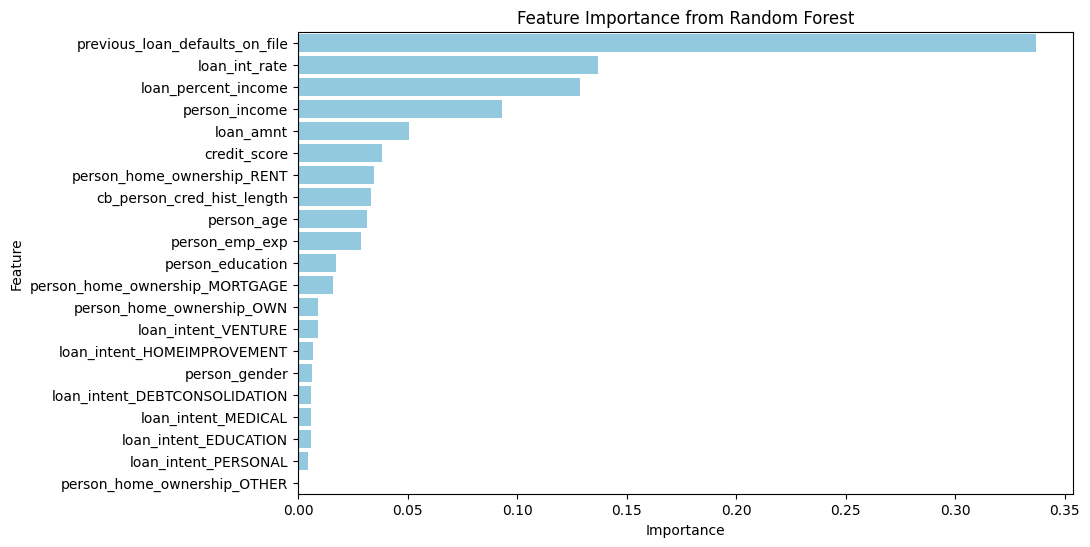

In [56]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [57]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

In [58]:
# Set threshold for feature importance (e.g., > 0.01)
threshold = 0.01
important_features = feature_importances[feature_importances['Importance'] > threshold]

# Extract selected feature names as a list
selected_features = important_features['Feature'].tolist()

# Create a new X_resampled DataFrame with only the important features
X_selected_resampled = X_resampled[selected_features]
print("Selected Features:")
print(X_selected_resampled.columns)


Selected Features:
Index(['previous_loan_defaults_on_file', 'loan_int_rate',
       'loan_percent_income', 'person_income', 'loan_amnt', 'credit_score',
       'person_home_ownership_RENT', 'cb_person_cred_hist_length',
       'person_age', 'person_emp_exp', 'person_education',
       'person_home_ownership_MORTGAGE'],
      dtype='object')


## Model Implementation

### Train Test Split

In [59]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_resampled, y_resampled, test_size=0.2, random_state=42)

In [60]:
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (50804, 12)
Testing features shape: (12702, 12)
Training labels shape: (50804,)
Testing labels shape: (12702,)


In [61]:
X_selected_resampled.columns

Index(['previous_loan_defaults_on_file', 'loan_int_rate',
       'loan_percent_income', 'person_income', 'loan_amnt', 'credit_score',
       'person_home_ownership_RENT', 'cb_person_cred_hist_length',
       'person_age', 'person_emp_exp', 'person_education',
       'person_home_ownership_MORTGAGE'],
      dtype='object')

### Defining Machine Learning Models

In [62]:
# Initialize the models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
nb_model = GaussianNB()
lgb_model = lgb.LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')  

# Train the models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)  

# Predict using the trained models
dt_pred = dt_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
nb_pred = nb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)  

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
nb_accuracy = accuracy_score(y_test, nb_pred)
lgb_accuracy = accuracy_score(y_test, lgb_pred)
xgb_accuracy = accuracy_score(y_test, xgb_pred)  

# Confusion Matrix
dt_conf_matrix = confusion_matrix(y_test, dt_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
nb_conf_matrix = confusion_matrix(y_test, nb_pred)
lgb_conf_matrix = confusion_matrix(y_test, lgb_pred)
xgb_conf_matrix = confusion_matrix(y_test, xgb_pred)  

# Classification Report
dt_class_report = classification_report(y_test, dt_pred)
rf_class_report = classification_report(y_test, rf_pred)
nb_class_report = classification_report(y_test, nb_pred)
lgb_class_report = classification_report(y_test, lgb_pred)
xgb_class_report = classification_report(y_test, xgb_pred)  

# Output Results
print("Decision Tree Model:")
print(f"Accuracy: {dt_accuracy:.4f}")
print("Confusion Matrix:")
print(dt_conf_matrix)
print("Classification Report:")
print(dt_class_report)

print("\nRandom Forest Model:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Confusion Matrix:")
print(rf_conf_matrix)
print("Classification Report:")
print(rf_class_report)

print("\nNaive Bayes Model:")
print(f"Accuracy: {nb_accuracy:.4f}")
print("Confusion Matrix:")
print(nb_conf_matrix)
print("Classification Report:")
print(nb_class_report)

print("\nLightGBM Model:")
print(f"Accuracy: {lgb_accuracy:.4f}")
print("Confusion Matrix:")
print(lgb_conf_matrix)
print("Classification Report:")
print(lgb_class_report)

print("\nXGBoost Model:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print("Confusion Matrix:")
print(xgb_conf_matrix)
print("Classification Report:")
print(xgb_class_report)

[LightGBM] [Info] Number of positive: 25398, number of negative: 25406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 50804, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499921 -> initscore=-0.000315
[LightGBM] [Info] Start training from score -0.000315
Decision Tree Model:
Accuracy: 0.9011
Confusion Matrix:
[[5683  664]
 [ 592 5763]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6347
           1       0.90      0.91      0.90      6355

    accuracy                           0.90     12702
   macro avg       0.90      0.90      0.90     12702
weighted avg       0.90      0.90      0.90     12702


Random F

### Model Validation before hyperparameter tuning

[LightGBM] [Info] Number of positive: 25398, number of negative: 25406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 50804, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499921 -> initscore=-0.000315
[LightGBM] [Info] Start training from score -0.000315
Decision Tree Model:
Accuracy: 0.9011
Error Rate: 0.0989
AUC: 0.9011
Confusion Matrix:
[[5683  664]
 [ 592 5763]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6347
           1       0.90      0.91      0.90      6355

    accuracy                           0.90     12702
   macro avg       0.90      0.90      0.90     12702
weighted avg       0.90      0.90

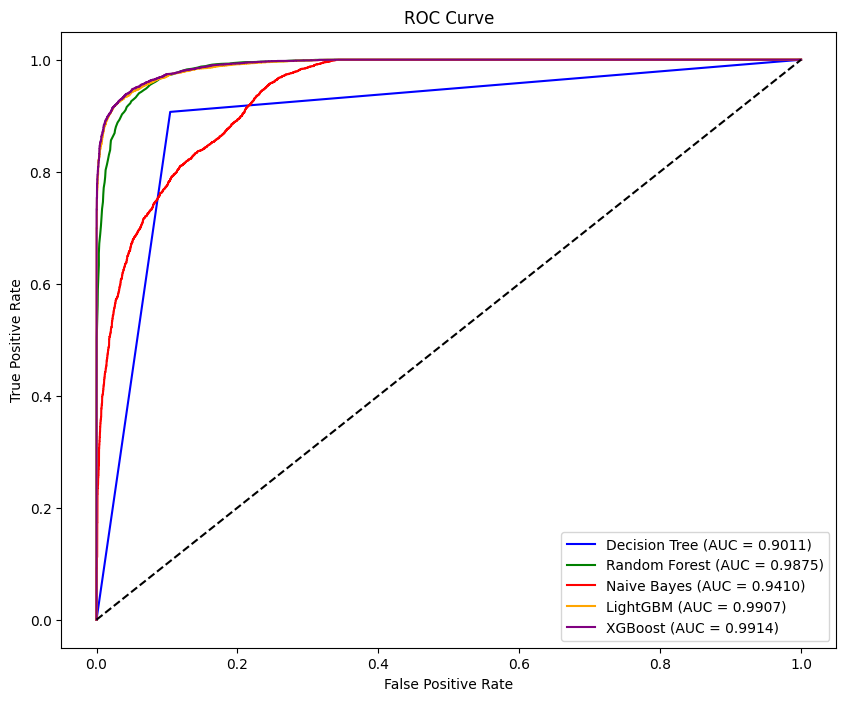

In [63]:
# Train the models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict using the trained models
dt_pred_prob = dt_model.predict_proba(X_test)[:, 1]  
rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]
nb_pred_prob = nb_model.predict_proba(X_test)[:, 1]
lgb_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
xgb_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC
dt_auc = roc_auc_score(y_test, dt_pred_prob)
rf_auc = roc_auc_score(y_test, rf_pred_prob)
nb_auc = roc_auc_score(y_test, nb_pred_prob)
lgb_auc = roc_auc_score(y_test, lgb_pred_prob)
xgb_auc = roc_auc_score(y_test, xgb_pred_prob)

# Calculate accuracy
dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
nb_accuracy = accuracy_score(y_test, nb_model.predict(X_test))
lgb_accuracy = accuracy_score(y_test, lgb_model.predict(X_test))
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

# Calculate error rate
dt_error_rate = 1 - dt_accuracy
rf_error_rate = 1 - rf_accuracy
nb_error_rate = 1 - nb_accuracy
lgb_error_rate = 1 - lgb_accuracy

# Confusion Matrix
dt_conf_matrix = confusion_matrix(y_test, dt_model.predict(X_test))
rf_conf_matrix = confusion_matrix(y_test, rf_model.predict(X_test))
nb_conf_matrix = confusion_matrix(y_test, nb_model.predict(X_test))
lgb_conf_matrix = confusion_matrix(y_test, lgb_model.predict(X_test))
xgb_conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_test))

# Classification Report
dt_class_report = classification_report(y_test, dt_model.predict(X_test))
rf_class_report = classification_report(y_test, rf_model.predict(X_test))
nb_class_report = classification_report(y_test, nb_model.predict(X_test))
lgb_class_report = classification_report(y_test, lgb_model.predict(X_test))
xgb_class_report = classification_report(y_test, xgb_model.predict(X_test))

# Output Results
print("Decision Tree Model:")
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Error Rate: {dt_error_rate:.4f}")
print(f"AUC: {dt_auc:.4f}")
print("Confusion Matrix:")
print(dt_conf_matrix)
print("Classification Report:")
print(dt_class_report)

print("\nRandom Forest Model:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Error Rate: {rf_error_rate:.4f}")
print(f"AUC: {rf_auc:.4f}")
print("Confusion Matrix:")
print(rf_conf_matrix)
print("Classification Report:")
print(rf_class_report)

print("\nNaive Bayes Model:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Error Rate: {nb_error_rate:.4f}")
print(f"AUC: {nb_auc:.4f}")
print("Confusion Matrix:")
print(nb_conf_matrix)
print("Classification Report:")
print(nb_class_report)

print("\nLightGBM Model:")
print(f"Accuracy: {lgb_accuracy:.4f}")
print(f"Error Rate: {lgb_error_rate:.4f}")
print(f"AUC: {lgb_auc:.4f}")
print("Confusion Matrix:")
print(lgb_conf_matrix)
print("Classification Report:")
print(lgb_class_report)

print("\nXGBoost Model:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Error Rate: {lgb_error_rate:.4f}")
print(f"AUC: {xgb_auc:.4f}")
print("Confusion Matrix:")
print(xgb_conf_matrix)
print("Classification Report:")
print(xgb_class_report)

# Plot ROC Curve for each model
plt.figure(figsize=(10, 8))
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pred_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_prob)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_pred_prob)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_pred_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_prob)

plt.plot(fpr_dt, tpr_dt, color='blue', label=f'Decision Tree (AUC = {dt_auc:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot(fpr_nb, tpr_nb, color='red', label=f'Naive Bayes (AUC = {nb_auc:.4f})')
plt.plot(fpr_lgb, tpr_lgb, color='orange', label=f'LightGBM (AUC = {lgb_auc:.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='purple', label=f'XGBoost (AUC = {xgb_auc:.4f})')

# Plotting the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Confusion Matrix and ROC Curve

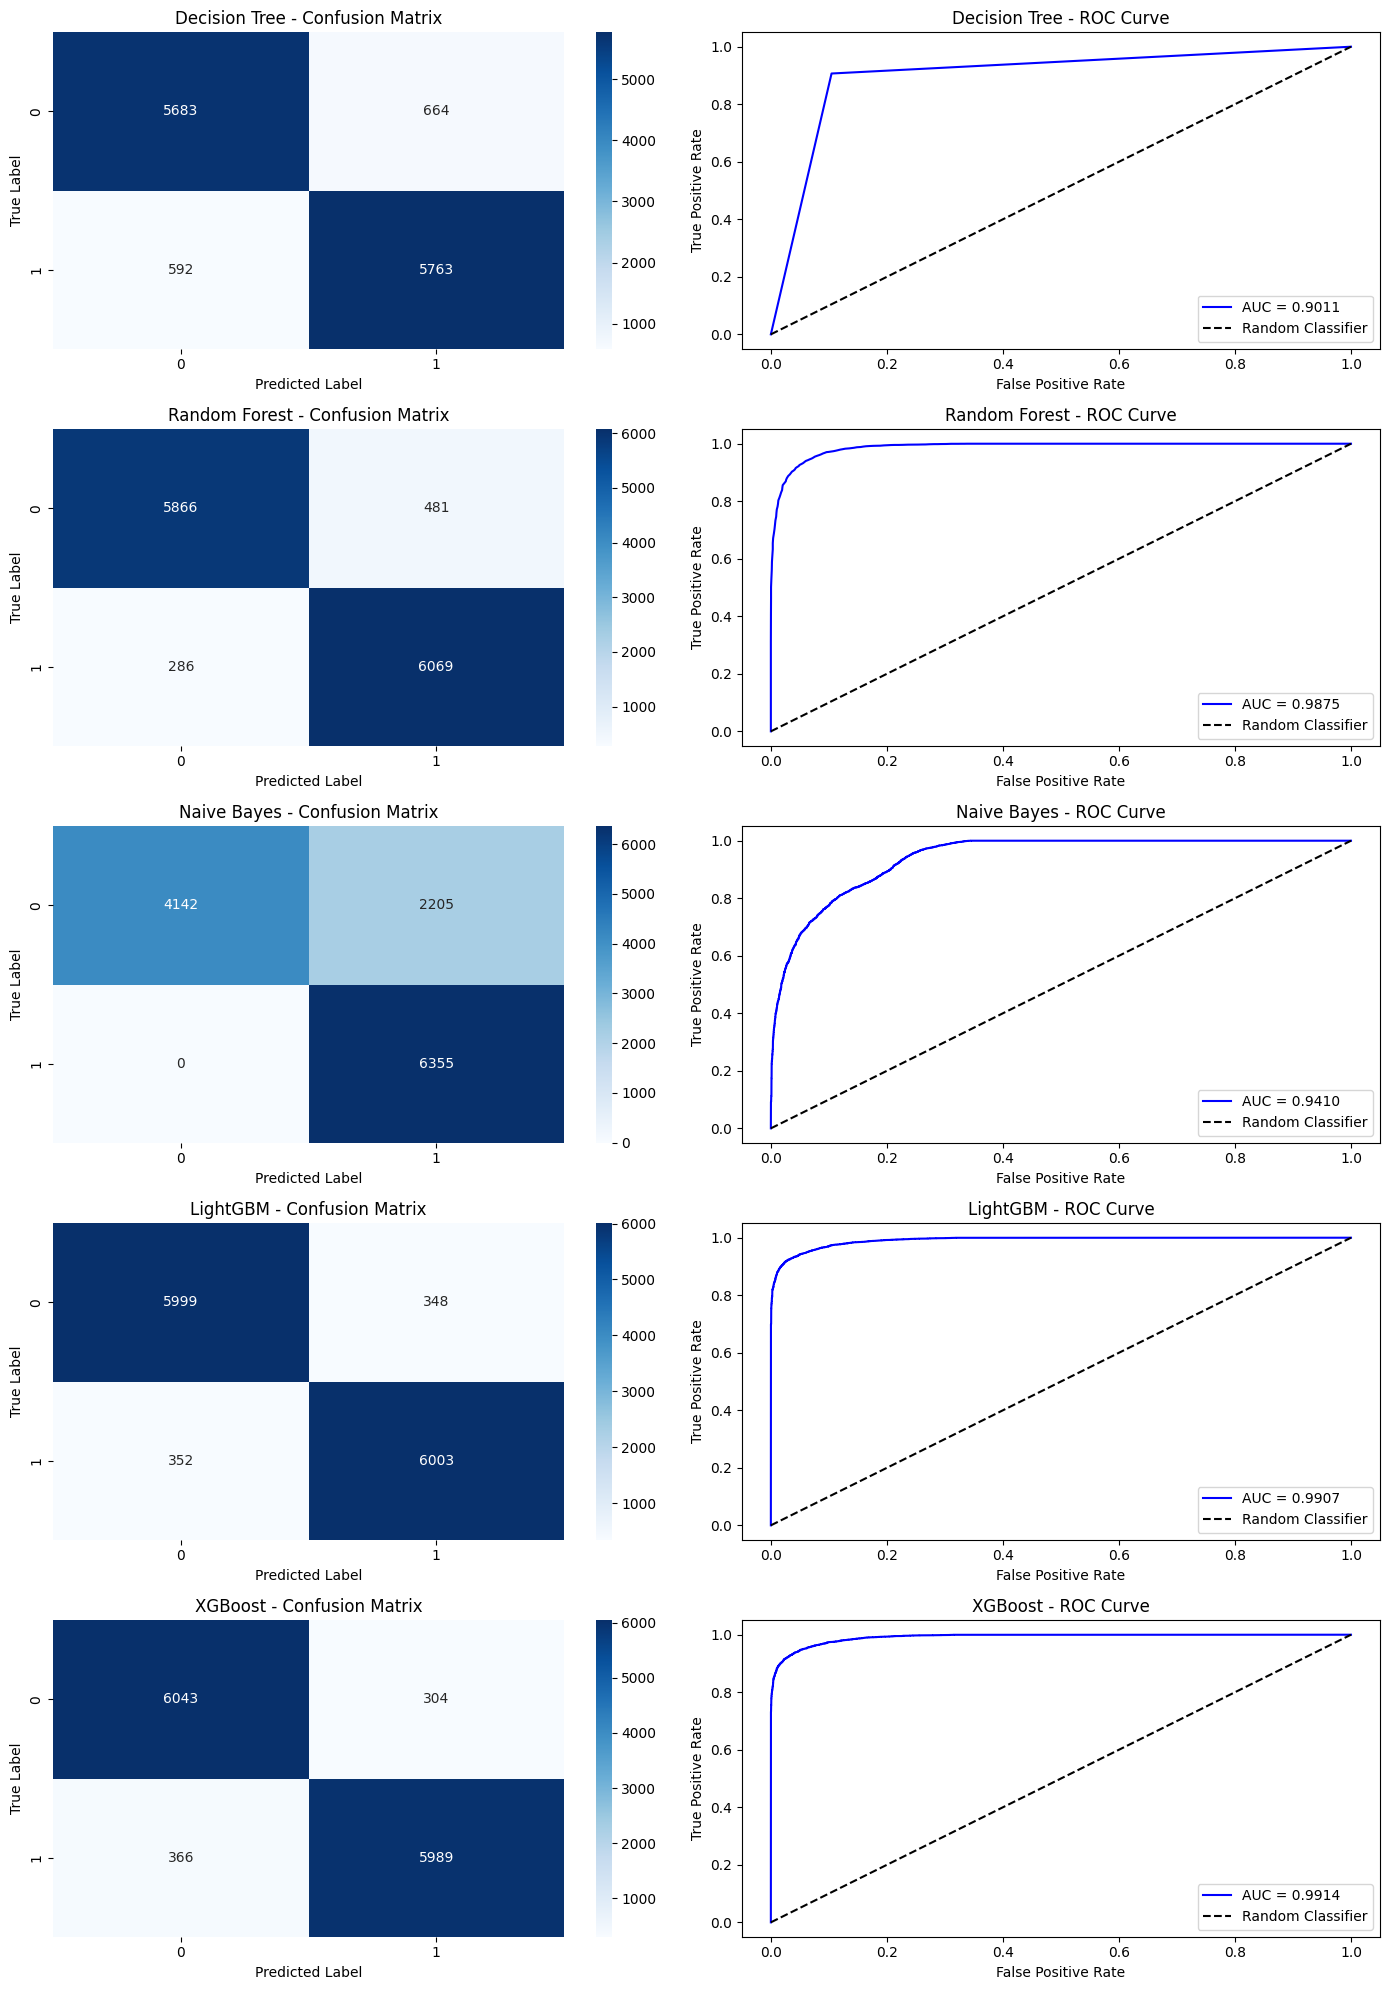

In [64]:
fig, axes = plt.subplots(len(["DT", "RF", "NB", "LGB", "XGB"]), 2, figsize=(14, 20))

# Define all models and predictions
models = [
    ("Decision Tree", dt_conf_matrix, dt_pred_prob, dt_auc),
    ("Random Forest", rf_conf_matrix, rf_pred_prob, rf_auc),
    ("Naive Bayes", nb_conf_matrix, nb_pred_prob, nb_auc),
    ("LightGBM", lgb_conf_matrix, lgb_pred_prob, lgb_auc),
    ("XGBoost", xgb_conf_matrix, xgb_pred_prob, xgb_auc)
]

for i, (model_name, conf_matrix, pred_prob, auc) in enumerate(models):
    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
    axes[i, 0].set_title(f"{model_name} - Confusion Matrix")
    axes[i, 0].set_xlabel("Predicted Label")
    axes[i, 0].set_ylabel("True Label")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    axes[i, 1].plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
    axes[i, 1].plot([0, 1], [0, 1], linestyle="--", color="black", label="Random Classifier")
    axes[i, 1].set_title(f"{model_name} - ROC Curve")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()


### Cross Validation Score and identify whether the initial models are good fit/underfit/overfit

In [65]:
# Define thresholds
LOW_ACCURACY_THRESHOLD = 0.90  # Threshold for underfitting
OVERFITTING_THRESHOLD = 0.03   # Accuracy gap for overfitting
VARIANCE_THRESHOLD = 0.01      # Threshold for variance (indicative of overfitting)
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model
}
# Loop through each model
for model_name, model in models.items():
    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    
    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_variance = np.var(cv_scores)

    # Determine fit status
    if train_accuracy < LOW_ACCURACY_THRESHOLD:
        fit_status = "Underfitting"
    elif train_accuracy == 1.0 or train_accuracy - test_accuracy > OVERFITTING_THRESHOLD:
        fit_status = "Overfitting"
    elif cv_variance > VARIANCE_THRESHOLD:
        fit_status = "Overfitting (High Variance)"
    elif abs(train_accuracy - test_accuracy) <= OVERFITTING_THRESHOLD and cv_variance <= VARIANCE_THRESHOLD:
        fit_status = "Good Fit"
    else:
        fit_status = "Good Fit"

    # Output results
    print(f"\n{model_name} Model:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Cross-Validation Mean Accuracy: {cv_mean:.4f}")
    print(f"Cross-Validation Variance: {cv_variance:.4f}")
    print(f"Fit Status: {fit_status}")



Decision Tree Model:
Training Accuracy: 1.0000
Test Accuracy: 0.9011
Cross-Validation Mean Accuracy: 0.8952
Cross-Validation Variance: 0.0000
Fit Status: Overfitting

Random Forest Model:
Training Accuracy: 1.0000
Test Accuracy: 0.9396
Cross-Validation Mean Accuracy: 0.9381
Cross-Validation Variance: 0.0000
Fit Status: Overfitting

Naive Bayes Model:
Training Accuracy: 0.8295
Test Accuracy: 0.8264
Cross-Validation Mean Accuracy: 0.8295
Cross-Validation Variance: 0.0000
Fit Status: Underfitting
[LightGBM] [Info] Number of positive: 22858, number of negative: 22865
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 45723, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499923 -> initscore=-0.000

## Hyperparameter Tuning and Reducing Overfitting

#### Decision Tree

In [66]:
dt_param_grid = {
    'max_depth': [3, 5, 7, 10],  
    'min_samples_split': [5, 10, 15],  
    'min_samples_leaf': [2, 4, 6],  
    'criterion': ['gini', 'entropy'],  # Keep both criteria for flexibility
    'max_features': ['sqrt', 'log2', 5]  
}

dt_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=10,  # 10-fold cross-validation for better generalization assessment
    scoring='accuracy',  
    n_jobs=-1,  
    verbose=2  
)
dt_grid_search.fit(X_train, y_train)

print(f"Best Parameters for Decision Tree: {dt_grid_search.best_params_}")
dt_model = dt_grid_search.best_estimator_

train_accuracy = accuracy_score(y_train, dt_model.predict(X_train))
test_accuracy = accuracy_score(y_test, dt_model.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting or underfitting
if train_accuracy > test_accuracy and (train_accuracy - test_accuracy) > 0.03:
    print("The model is overfitting.")
elif train_accuracy < test_accuracy:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.

tried grid search for rfc but slow

#### Random Forest Classifier

In [67]:
# Reduced Random Forest Hyperparameter Distribution for Faster Search
rf_param_dist = {
    'n_estimators': randint(100, 300),  
    'max_depth': [5, 10],  
    'min_samples_split': randint(2, 10),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['sqrt', 'log2',5],  
    'criterion': ['gini','entropy']  
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=5,  
    cv=10,  
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1  
)

# Fit the model
rf_random_search.fit(X_train, y_train)

# Best Parameters for Random Forest
print(f"Best Parameters for Random Forest: {rf_random_search.best_params_}")

# Retrain the model with the best parameters
rf_model = rf_random_search.best_estimator_

# Evaluate on test data
train_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
test_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting or underfitting
if train_accuracy > test_accuracy and (train_accuracy - test_accuracy) > 0.03:
    print("The model is overfitting.")
elif train_accuracy < test_accuracy:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=   7.5s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=   7.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=   7.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=   7.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=   7.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total time=   7.7s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=171; total 

### Naive Bayes

In [68]:
# Define the parameter grid for Naive Bayes
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Different values for var_smoothing
}

# Initialize GridSearchCV for Naive Bayes
nb_grid_search = GridSearchCV(
    estimator=GaussianNB(),  
    param_grid=nb_param_grid,  
    cv=10,  
    scoring='accuracy',  
    n_jobs=-1, 
    verbose=2  
)

# Fit the model
nb_grid_search.fit(X_train, y_train)

# Best Parameters for Naive Bayes
print(f"Best Parameters for Naive Bayes: {nb_grid_search.best_params_}")

# Retrain the model with the best parameters
nb_model = nb_grid_search.best_estimator_



train_accuracy = accuracy_score(y_train, nb_model.predict(X_train))
test_accuracy = accuracy_score(y_test, nb_model.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting or underfitting
if train_accuracy > test_accuracy and (train_accuracy - test_accuracy) > 0.03:
    print("The model is overfitting.")
elif train_accuracy < test_accuracy:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")


Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smo

### Light GBM

In [69]:

# LightGBM Hyperparameter Distribution for Randomized Search
lgb_param_dist = {
    'num_leaves': [15, 31, 50],  
    'max_depth': [-1, 5, 10],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'n_estimators': [100, 200, 300],  
    'subsample': [0.6, 0.7, 0.8],  
    'colsample_bytree': [0.7, 0.8, 0.9],  
    'min_data_in_leaf': [20, 30, 50],  
    'lambda_l1': [0.0, 0.1, 0.5],  #regularization
    'lambda_l2': [0.0, 0.1, 0.5] 
}

# Randomized Search for LightGBM
lgb_random_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_distributions=lgb_param_dist,
    n_iter=10,  
    cv=10,  
    scoring='accuracy',  
    n_jobs=-1,  
    random_state=42,  
    verbose=2  
)

# Fit the model
lgb_random_search.fit(X_train, y_train)

# Best Parameters for LightGBM
print(f"Best Parameters for LightGBM: {lgb_random_search.best_params_}")

# Retrain the model with the best parameters
lgb_model = lgb_random_search.best_estimator_



train_accuracy = accuracy_score(y_train, lgb_model.predict(X_train))
test_accuracy = accuracy_score(y_test, lgb_model.predict(X_test))

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check for overfitting or underfitting
if train_accuracy > test_accuracy and (train_accuracy - test_accuracy) > 0.03:
    print("The model is overfitting.")
elif train_accuracy < test_accuracy:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 wi

### XGBoost

In [70]:

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 150],        
    'max_depth': [3, 5, 7],                 
    'learning_rate': [0.01, 0.1, 0.2],     
    'subsample': [0.8, 1.0],                
    'colsample_bytree': [0.8, 1.0],        
    'gamma': [0, 0.1, 0.2],                 
    'reg_alpha': [0, 0.1, 0.5],           
    'reg_lambda': [1, 1.5, 2]               
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='roc_auc',          
    n_iter=10,                 
    cv=10,                      
    verbose=1,                  
    random_state=42,            
)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best AUC Score:", best_score)

# Retrain the model with the best parameters
xgb_model_best = random_search.best_estimator_

# Calculate accuracy scores using the trained model
train_accuracy = accuracy_score(y_train, (xgb_model_best.predict_proba(X_train)[:, 1] > 0.5).astype(int))
test_accuracy = accuracy_score(y_test, (xgb_model_best.predict_proba(X_test)[:, 1] > 0.5).astype(int))

# Evaluate on training and test data
train_auc = roc_auc_score(y_train, xgb_model_best.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, xgb_model_best.predict_proba(X_test)[:, 1])

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Check for overfitting or underfitting
if train_accuracy > test_accuracy and (train_accuracy - test_accuracy) > 0.03:
    print("The model is overfitting.")
elif train_accuracy < test_accuracy:
    print("The model is underfitting.")
else:
    print("The model is a good fit.")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best AUC Score: 0.9907429831338863
Training Accuracy: 0.9685
Test Accuracy: 0.9473
Training AUC: 0.9965
Test AUC: 0.9912
The model is a good fit.


In [71]:

# Decision Tree
print(f"Best Parameters for Decision Tree: {dt_model.get_params()}")

# Random Forest
print(f"Best Parameters for Random Forest: {rf_model.get_params()}")

# Naive Bayes
print(f"Best Parameters for Naive Bayes: {nb_model.get_params()}")

# LightGBM
print(f"Best Parameters for LightGBM: {lgb_model.get_params()}")

# XGBoost
print(f"Best Parameters for XGBoost: {xgb_model.get_params()}")


Best Parameters for Decision Tree: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Best Parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 257, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Best Parameters for Naive Bayes: {'priors': None, 'var_smoothing': 1e-06}
Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'importance_type': 'split', 'learning_rate': 

#### Model Validation after hyperparameter tuning

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 25398, number of negative: 25406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] 

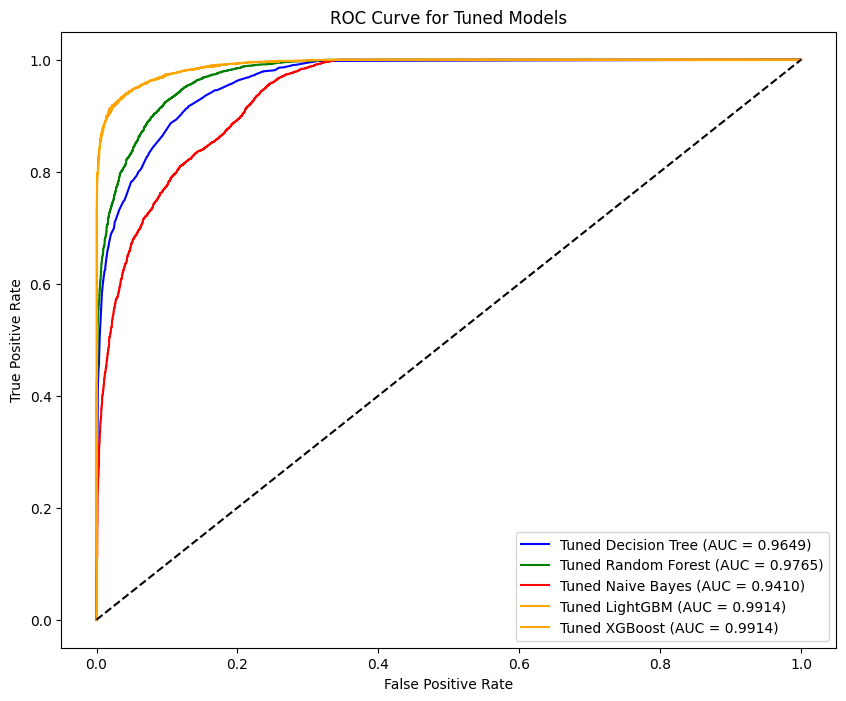

In [72]:
# These should be fitted before making predictions
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predict using the tuned models
tuned_dt_pred_prob = dt_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
tuned_rf_pred_prob = rf_model.predict_proba(X_test)[:, 1]
tuned_nb_pred_prob = nb_model.predict_proba(X_test)[:, 1]
tuned_lgb_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
tuned_xgb_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC, Accuracy, Confusion Matrix, and Classification Report
tuned_dt_auc = roc_auc_score(y_test, tuned_dt_pred_prob)
tuned_rf_auc = roc_auc_score(y_test, tuned_rf_pred_prob)
tuned_nb_auc = roc_auc_score(y_test, tuned_nb_pred_prob)
tuned_lgb_auc = roc_auc_score(y_test, tuned_lgb_pred_prob)
tuned_xgb_auc = roc_auc_score(y_test, tuned_xgb_pred_prob)

# Calculate accuracy
tuned_dt_accuracy = accuracy_score(y_test, dt_model.predict(X_test))
tuned_rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
tuned_nb_accuracy = accuracy_score(y_test, nb_model.predict(X_test))
tuned_lgb_accuracy = accuracy_score(y_test, lgb_model.predict(X_test))
tuned_xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))


# Confusion Matrix
tuned_dt_conf_matrix = confusion_matrix(y_test, dt_model.predict(X_test))
tuned_rf_conf_matrix = confusion_matrix(y_test, rf_model.predict(X_test))
tuned_nb_conf_matrix = confusion_matrix(y_test, nb_model.predict(X_test))
tuned_lgb_conf_matrix = confusion_matrix(y_test, lgb_model.predict(X_test))
tuned_xgb_conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_test))


# Classification Report
tuned_dt_class_report = classification_report(y_test, dt_model.predict(X_test))
tuned_rf_class_report = classification_report(y_test, rf_model.predict(X_test))
tuned_nb_class_report = classification_report(y_test, nb_model.predict(X_test))
tuned_lgb_class_report = classification_report(y_test, lgb_model.predict(X_test))
tuned_xgb_class_report = classification_report(y_test, xgb_model.predict(X_test))

# Calculate Error Rate
tuned_dt_error_rate = 1 - tuned_dt_accuracy
tuned_rf_error_rate = 1 - tuned_rf_accuracy
tuned_nb_error_rate = 1 - tuned_nb_accuracy
tuned_lgb_error_rate = 1 - tuned_lgb_accuracy
tuned_xgb_error_rate = 1 - tuned_xgb_accuracy

# Output Results with Error Rate
print("Tuned Decision Tree Model:")
print(f"Accuracy: {tuned_dt_accuracy:.4f}")
print(f"Error Rate: {tuned_dt_error_rate:.4f}")
print(f"AUC: {tuned_dt_auc:.4f}")
print("Confusion Matrix:")
print(tuned_dt_conf_matrix)
print("Classification Report:")
print(tuned_dt_class_report)

print("\nTuned Random Forest Model:")
print(f"Accuracy: {tuned_rf_accuracy:.4f}")
print(f"Error Rate: {tuned_rf_error_rate:.4f}")
print(f"AUC: {tuned_rf_auc:.4f}")
print("Confusion Matrix:")
print(tuned_rf_conf_matrix)
print("Classification Report:")
print(tuned_rf_class_report)

print("\nTuned Naive Bayes Model:")
print(f"Accuracy: {tuned_nb_accuracy:.4f}")
print(f"Error Rate: {tuned_nb_error_rate:.4f}")
print(f"AUC: {tuned_nb_auc:.4f}")
print("Confusion Matrix:")
print(tuned_nb_conf_matrix)
print("Classification Report:")
print(tuned_nb_class_report)

print("\nTuned LightGBM Model:")
print(f"Accuracy: {tuned_lgb_accuracy:.4f}")
print(f"Error Rate: {tuned_lgb_error_rate:.4f}")
print(f"AUC: {tuned_lgb_auc:.4f}")
print("Confusion Matrix:")
print(tuned_lgb_conf_matrix)
print("Classification Report:")
print(tuned_lgb_class_report)

print("Tuned XGBoost Model:")
print(f"Accuracy: {tuned_xgb_accuracy:.4f}")
print(f"Error Rate: {tuned_xgb_error_rate:.4f}")
print(f"AUC: {tuned_xgb_auc:.4f}")
print("Confusion Matrix:")
print(tuned_xgb_conf_matrix)
print("Classification Report:")
print(tuned_xgb_class_report)

# Plot ROC Curve for each tuned model
plt.figure(figsize=(10, 8))
fpr_tuned_dt, tpr_tuned_dt, _ = roc_curve(y_test, tuned_dt_pred_prob)
fpr_tuned_rf, tpr_tuned_rf, _ = roc_curve(y_test, tuned_rf_pred_prob)
fpr_tuned_nb, tpr_tuned_nb, _ = roc_curve(y_test, tuned_nb_pred_prob)
fpr_tuned_lgb, tpr_tuned_lgb, _ = roc_curve(y_test, tuned_lgb_pred_prob)
fpr_tuned_xgb, tpr_tuned_xgb, _ = roc_curve(y_test, tuned_xgb_pred_prob)

plt.plot(fpr_tuned_dt, tpr_tuned_dt, color='blue', label=f'Tuned Decision Tree (AUC = {tuned_dt_auc:.4f})')
plt.plot(fpr_tuned_rf, tpr_tuned_rf, color='green', label=f'Tuned Random Forest (AUC = {tuned_rf_auc:.4f})')
plt.plot(fpr_tuned_nb, tpr_tuned_nb, color='red', label=f'Tuned Naive Bayes (AUC = {tuned_nb_auc:.4f})')
plt.plot(fpr_tuned_lgb, tpr_tuned_lgb, color='orange', label=f'Tuned LightGBM (AUC = {tuned_lgb_auc:.4f})')
plt.plot(fpr_tuned_xgb, tpr_tuned_xgb, color='orange', label=f'Tuned XGBoost (AUC = {tuned_xgb_auc:.4f})')


# Plotting the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.title('ROC Curve for Tuned Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


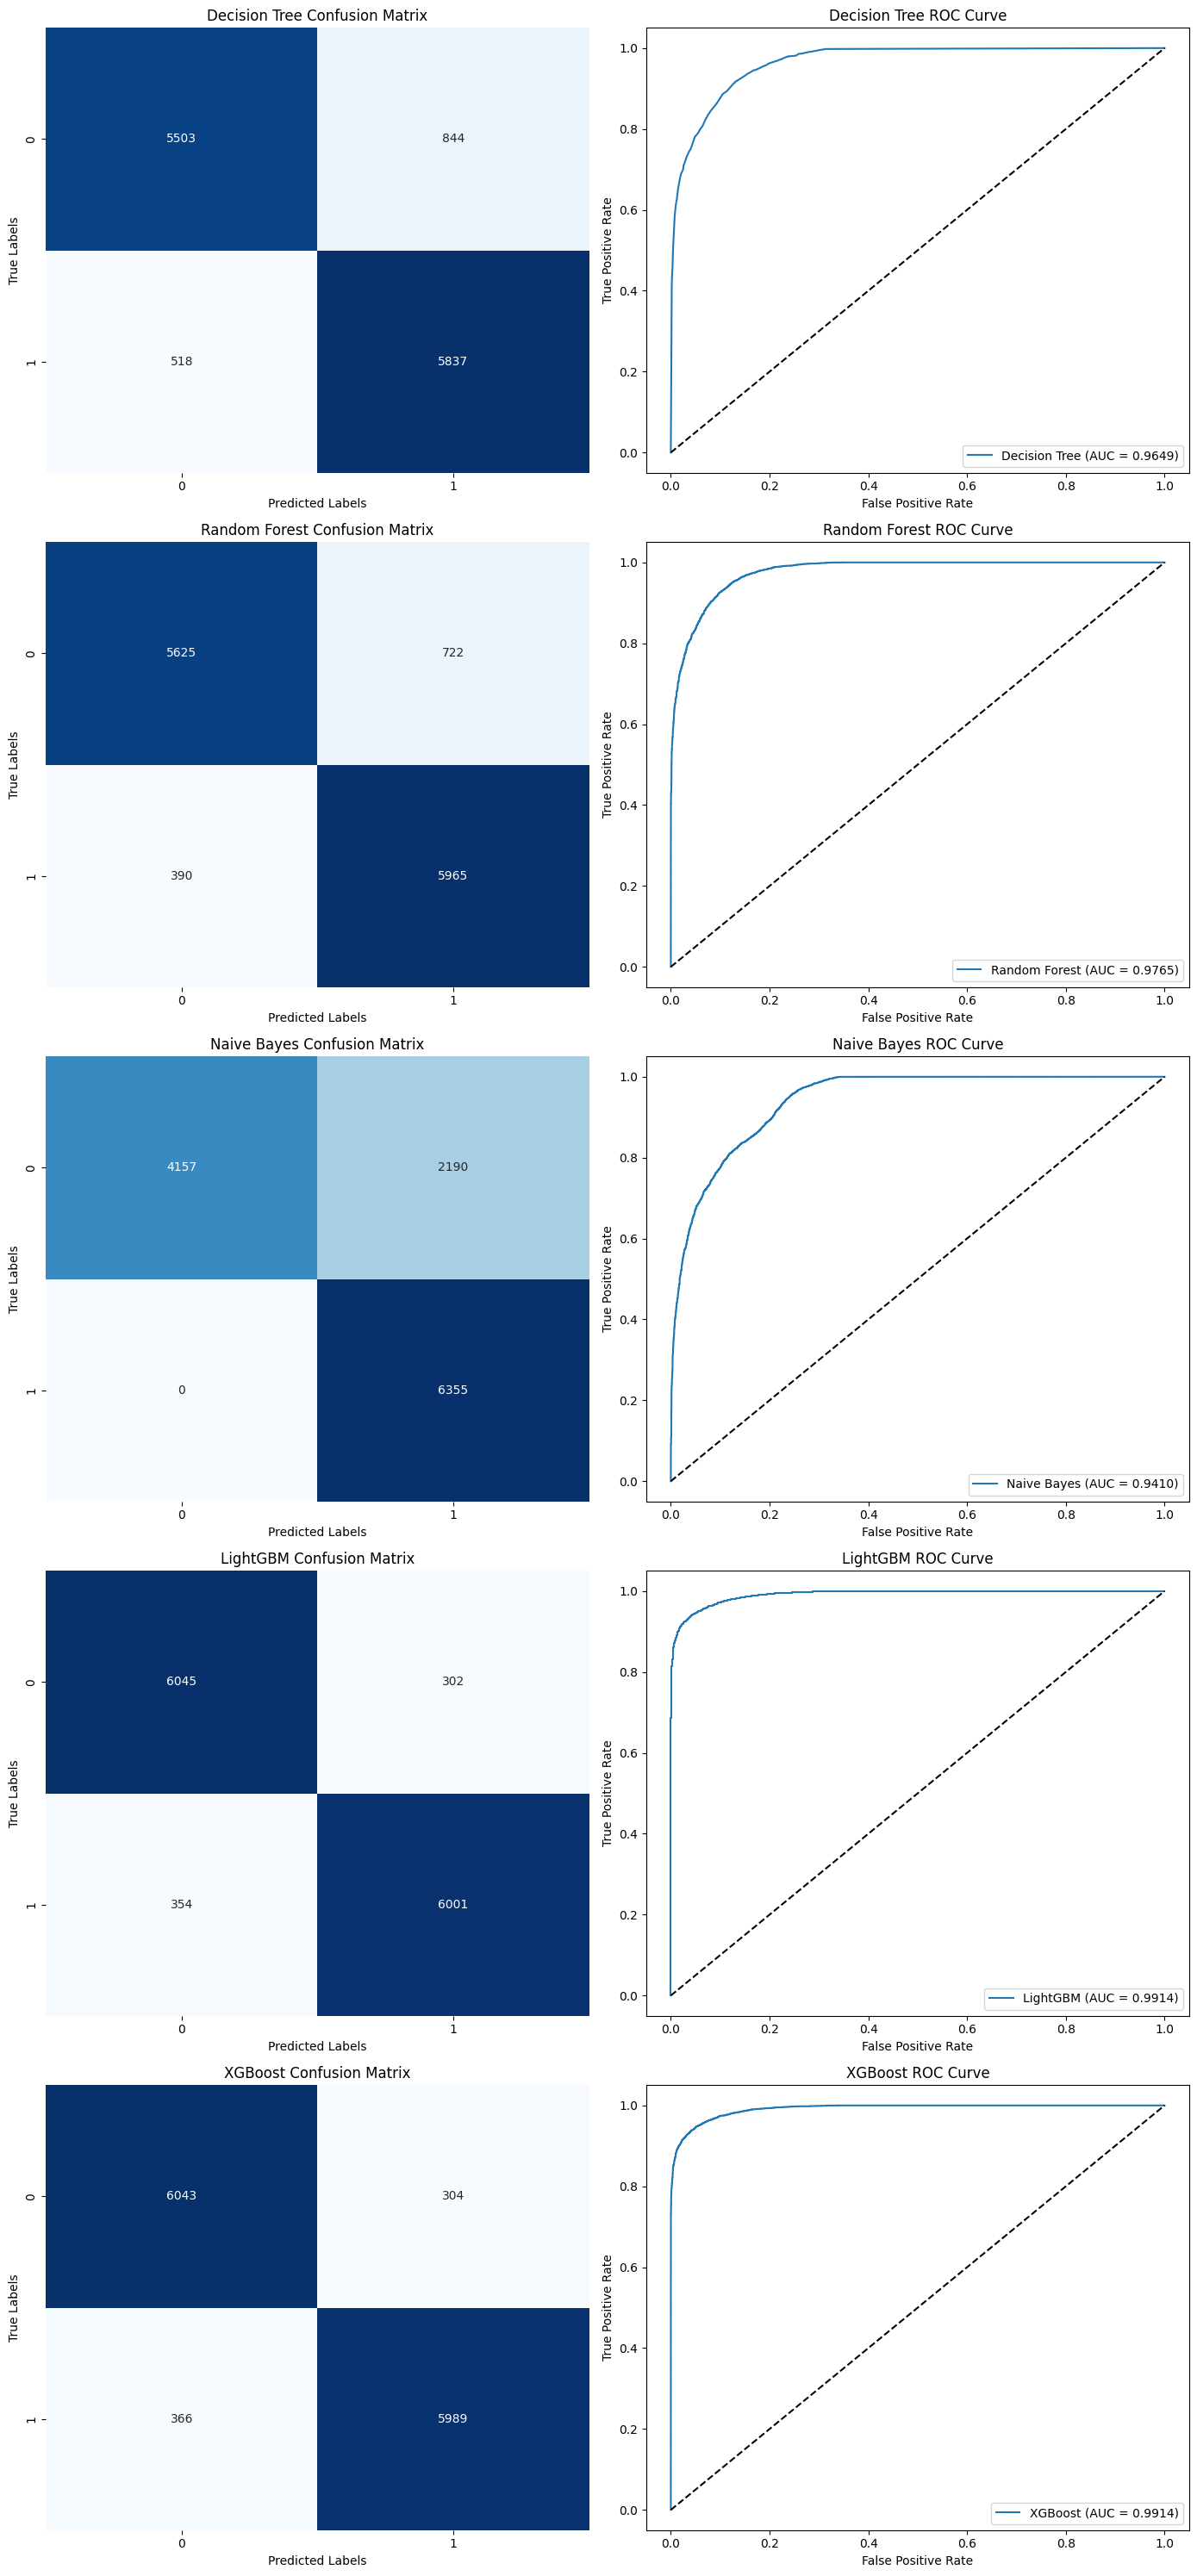

In [73]:
fig, axs = plt.subplots(5, 2, figsize=(14, 30))

# List of models and their associated prediction probabilities
models = [
    ('Decision Tree', dt_model, tuned_dt_pred_prob),
    ('Random Forest', rf_model, tuned_rf_pred_prob),
    ('Naive Bayes', nb_model, tuned_nb_pred_prob),
    ('LightGBM', lgb_model, tuned_lgb_pred_prob),
    ('XGBoost', xgb_model, tuned_xgb_pred_prob)
]

for i, (model_name, model, pred_prob) in enumerate(models):
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i, 0], cbar=False)
    axs[i, 0].set_title(f'{model_name} Confusion Matrix')
    axs[i, 0].set_xlabel('Predicted Labels')
    axs[i, 0].set_ylabel('True Labels')
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    axs[i, 1].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, pred_prob):.4f})')
    axs[i, 1].plot([0, 1], [0, 1], linestyle='--', color='black')  # Diagonal line
    axs[i, 1].set_title(f'{model_name} ROC Curve')
    axs[i, 1].set_xlabel('False Positive Rate')
    axs[i, 1].set_ylabel('True Positive Rate')
    axs[i, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

### Visualisation of models fit

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [W

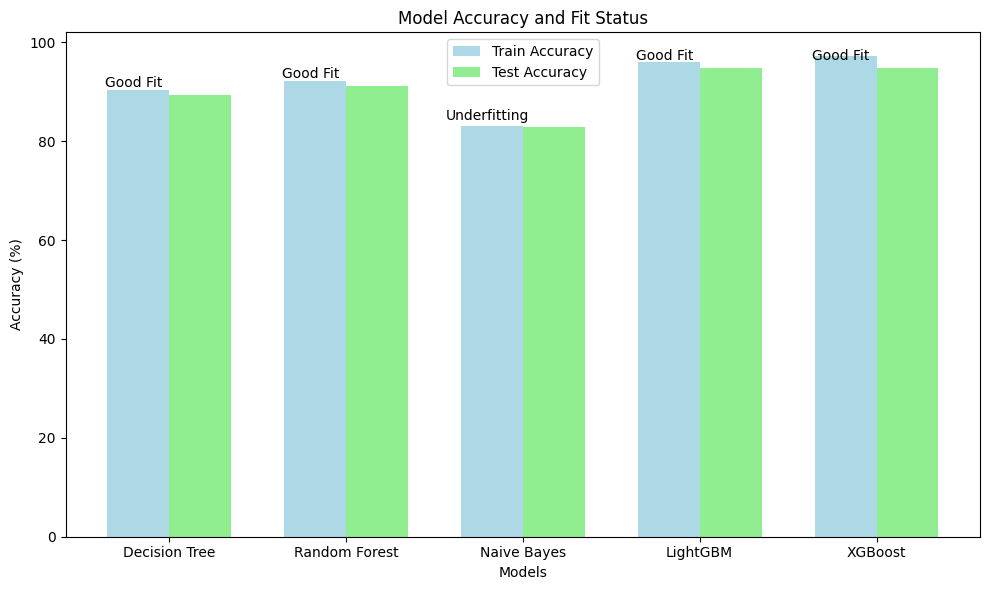

In [74]:
# Define thresholds
LOW_ACCURACY_THRESHOLD = 0.90  # Threshold for underfitting
OVERFITTING_THRESHOLD = 0.03   # Accuracy gap for overfitting
VARIANCE_THRESHOLD = 0.01      # Threshold for variance (indicative of overfitting)

# Create a dictionary of models for easy iteration
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'LightGBM': lgb_model,
    'XGBoost' : xgb_model
}

model_names = []
train_accuracies = []
test_accuracies = []
fit_status = []

for model_name, model in models.items():
    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    
    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_variance = np.var(cv_scores)

    # Determine fit status
    if train_accuracy < LOW_ACCURACY_THRESHOLD:
        fit_status_label = "Underfitting"
        color = 'orange'
    elif train_accuracy == 1.0 or train_accuracy - test_accuracy > OVERFITTING_THRESHOLD:
        fit_status_label = "Overfitting"
        color = 'red'
    elif cv_variance > VARIANCE_THRESHOLD:
        fit_status_label = "Overfitting (High Variance)"
        color = 'red'
    elif abs(train_accuracy - test_accuracy) <= OVERFITTING_THRESHOLD and cv_variance <= VARIANCE_THRESHOLD:
        fit_status_label = "Good Fit"
        color = 'blue'
    else:
        fit_status_label = "Good Fit"
        color = 'blue'

    model_names.append(model_name)
    train_accuracies.append(train_accuracy * 100)  
    test_accuracies.append(test_accuracy * 100)    
    fit_status.append(fit_status_label)

x = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
ax.bar(x - bar_width/2, train_accuracies, bar_width, label='Train Accuracy', color='lightblue')
ax.bar(x + bar_width/2, test_accuracies, bar_width, label='Test Accuracy', color='lightgreen')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy and Fit Status')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
for i in range(len(model_names)):
    ax.text(x[i] - 0.2, test_accuracies[i] + 1, fit_status[i], ha='center', va='bottom', color='black')
plt.tight_layout()
plt.show()


#### Final Cross Validation Score for all models

In [75]:
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'LightGBM': lgb_model,
    'XGBoost' : xgb_model
}

# Perform 10-fold cross-validation for all models
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')  
    print(f"\n{model_name} Model:")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")




Decision Tree Model:
Cross-Validation Accuracy: 0.8889 ± 0.0033

Random Forest Model:
Cross-Validation Accuracy: 0.9114 ± 0.0036

Naive Bayes Model:
Cross-Validation Accuracy: 0.8308 ± 0.0049
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 22858, number of negative: 22865
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

Decision Tree Model: The accuracy is 0.8889 with a standard deviation of 0.0033. This indicates relatively stable performance but may not be the best model compared to others.
Random Forest Model: With an accuracy of 0.9115 ± 0.0035, it performs well and is quite stable. Random Forest models generally provide good performance with better generalization compared to decision trees.
Naive Bayes Model: The accuracy is 0.8308 ± 0.0049. This is lower compared to the other models, indicating that Naive Bayes might not be suitable for this dataset.
LightGBM Model: It has the highest accuracy of 0.9475 ± 0.0036. This suggests that LightGBM performs exceptionally well and is quite stable.
XGBoost Model: The accuracy is 0.9461 ± 0.0038, which is very close to LightGBM. Both XGBoost and LightGBM are strong contenders in terms of performance.

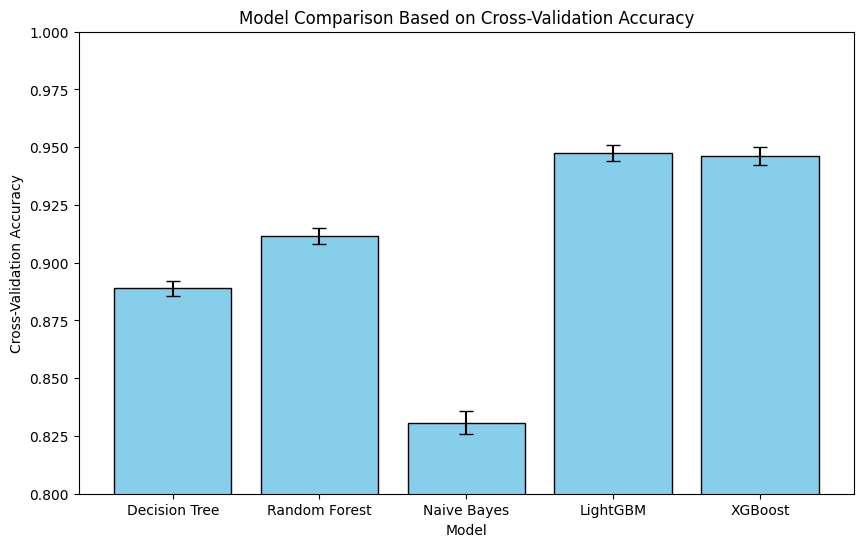

In [76]:
# Model names
models = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'LightGBM', 'XGBoost']

# Cross-validation means and standard deviations
cv_means = [0.8889, 0.9115, 0.8308, 0.9475, 0.9461]
cv_stds = [0.0033, 0.0035, 0.0049, 0.0036, 0.0038]

# Create the plot
plt.figure(figsize=(10,6))
plt.bar(models, cv_means, yerr=cv_stds, capsize=5, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Comparison Based on Cross-Validation Accuracy')
plt.ylim(0.8, 1)  
# Show the plot
plt.show()


In [77]:


# Dictionary of models
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model
}

# Number of bootstrap samples
n_bootstrap = 50

# Initialize dictionary to store bootstrap results
bootstrap_results = {}

# Perform bootstrap sampling and evaluation
for model_name, model in models.items():
    accuracies = []
    for _ in range(n_bootstrap):
        # Create a bootstrap sample with replacement from the training data
        X_bootstrap, y_bootstrap = resample(X_train, y_train, replace=True)
        
        # Fit the model on the bootstrap sample
        model.fit(X_bootstrap, y_bootstrap)
        
        # Evaluate on the test set
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    # Store mean and standard deviation of accuracies
    bootstrap_results[model_name] = {
        'Mean Accuracy': np.mean(accuracies),
        'Std Deviation': np.std(accuracies)
    }

for model_name, results in bootstrap_results.items():
    print(f"\n{model_name} Model:")
    print(f"Mean Accuracy: {results['Mean Accuracy']:.4f}")
    print(f"Standard Deviation: {results['Std Deviation']:.4f}")


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 25432, number of negative: 25372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] 

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 2296, number of negative: 2276
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 4572, number of use

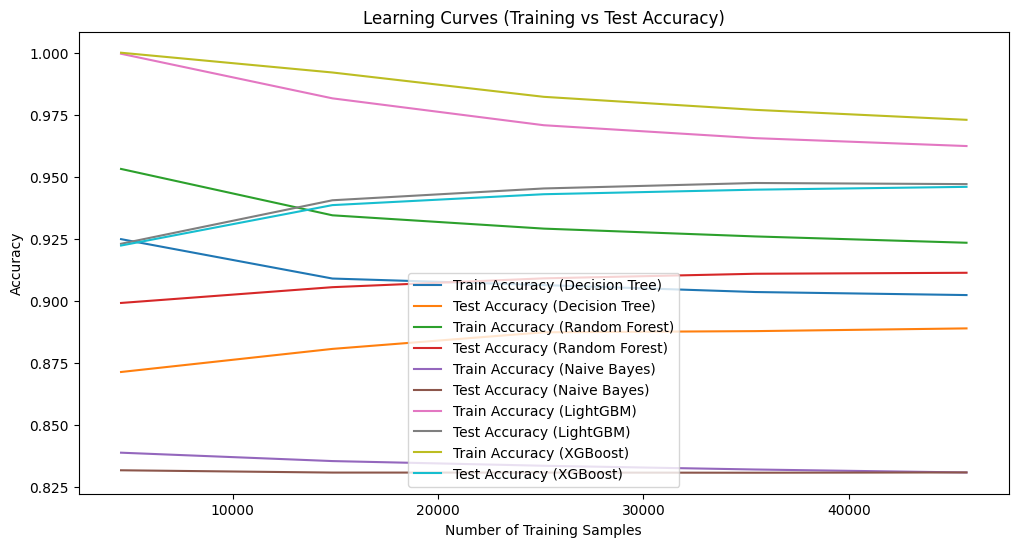

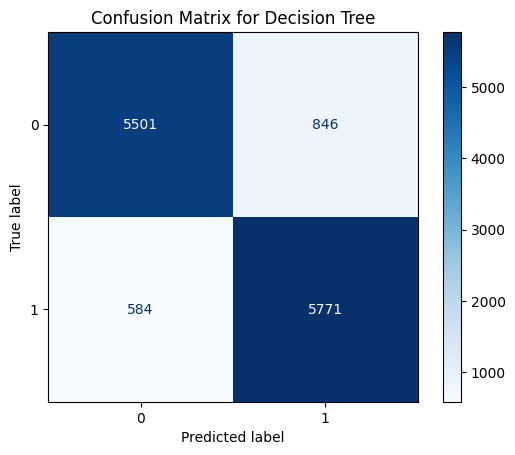

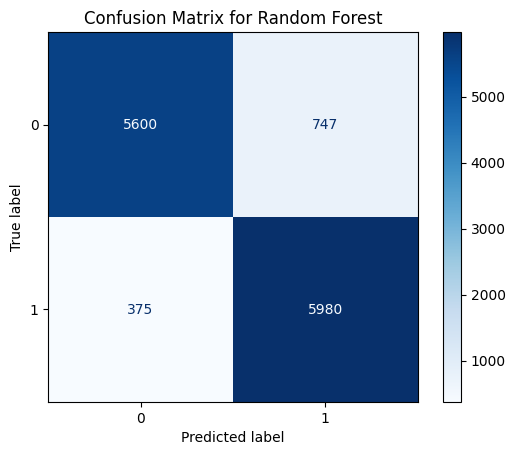

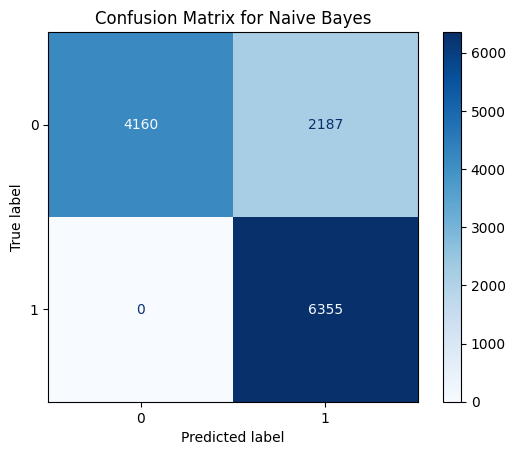

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


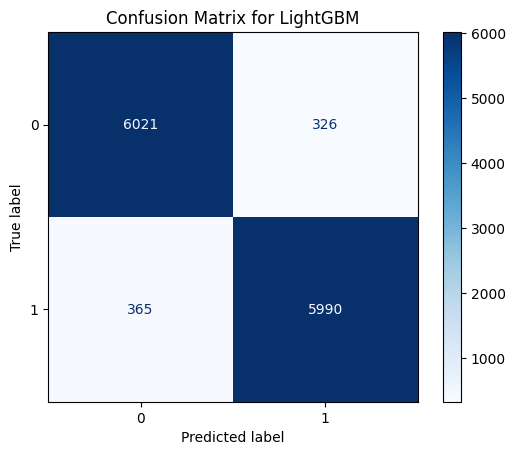

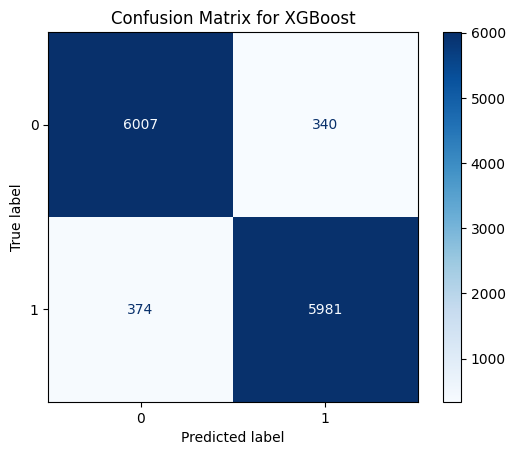

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


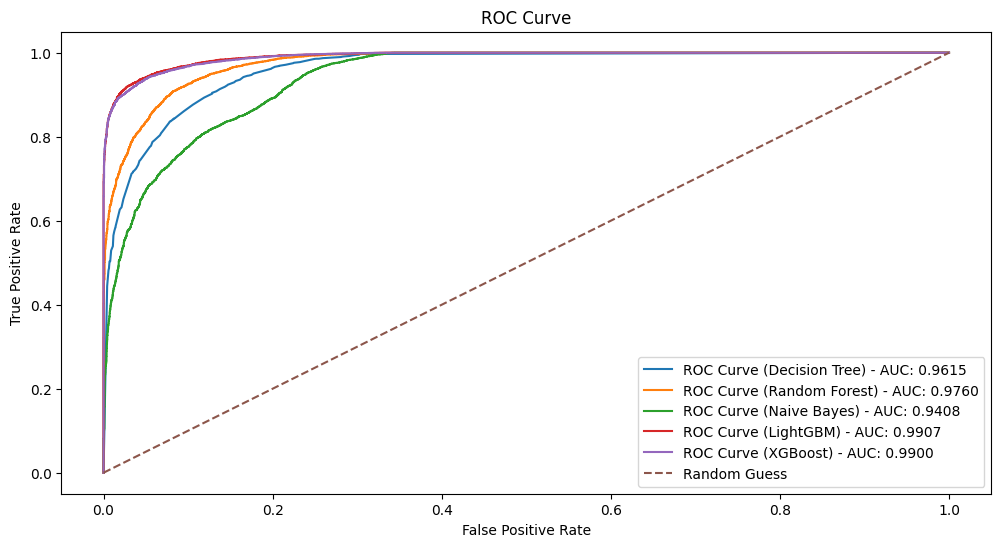

In [78]:
# Create a dictionary of models for easy iteration (including the tuned Random Forest model)
models = {
    'Decision Tree': dt_model,  # Decision Tree model
    'Random Forest': rf_model,  # Tuned Random Forest model
    'Naive Bayes': nb_model,    # Naive Bayes model
    'LightGBM': lgb_model,      # LightGBM model
    'XGBoost' : xgb_model
}

# 1. Learning Curves (Training vs Test Accuracy) for all models
plt.figure(figsize=(12, 6))

for model_name, model in models.items():
    train_sizes, train_accuracy, test_accuracy = learning_curve(model, X_train, y_train, cv=10, scoring='accuracy')
    
    # Plot learning curves
    plt.plot(train_sizes, train_accuracy.mean(axis=1), label=f'Train Accuracy ({model_name})')
    plt.plot(train_sizes, test_accuracy.mean(axis=1), label=f'Test Accuracy ({model_name})')

plt.title('Learning Curves (Training vs Test Accuracy)')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 2. Confusion Matrix for all models
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# 3. ROC Curve & AUC for all models
plt.figure(figsize=(12, 6))

for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=f'ROC Curve ({model_name}) - AUC: {auc:.4f}')

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [81]:
y_pred = lgb_model.predict(X_test)  

predictions_df = pd.DataFrame({
    'Actual': y_test,  
    'Predicted': y_pred  
})

print("Actual vs Predicted for 20 Rows:")
print(predictions_df.head(20))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the Test Set: {accuracy:.4f}")


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Actual vs Predicted for 20 Rows:
       Actual  Predicted
21519       0          0
53657       1          1
1791        0          0
12082       0          0
11762       0          0
3593        0          0
41286       1          1
25240       0          0
30332       0          0
57495       1          1
23617       1          1
36117       0          0
1422        0          0
13667       0          0
21640       0          0
34694       0          0
49457       1          1
36783       0          0
61295       1          1
24957       1          1

Accuracy on the Test Set: 0.9456


## Appendix

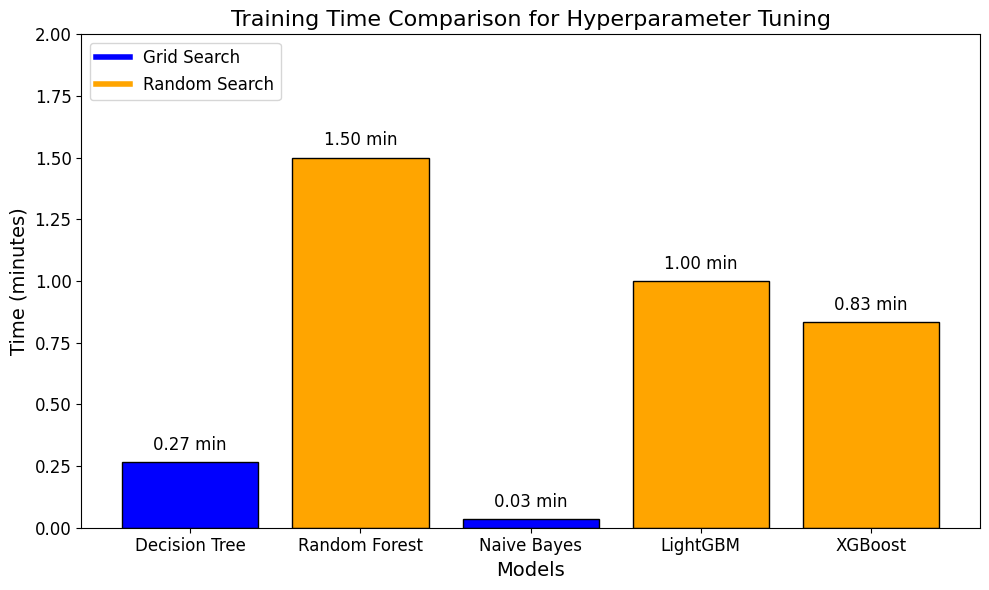

In [82]:
models = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'LightGBM', 'XGBoost']
times = [16 / 60, 1.5, 2 / 60, 1, 50 / 60]  # Training times in minutes
search_types = ['Grid Search', 'Random Search', 'Grid Search', 'Random Search', 'Random Search']
colors = ['blue' if search == 'Grid Search' else 'orange' for search in search_types]


plt.figure(figsize=(10, 6))
bars = plt.bar(models, times, color=colors, edgecolor='black')

plt.title('Training Time Comparison for Hyperparameter Tuning', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Time (minutes)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 2)  

for i, time in enumerate(times):
    plt.text(i, time + 0.05, f'{time:.2f} min', ha='center', fontsize=12)
plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='Grid Search'),
    plt.Line2D([0], [0], color='orange', lw=4, label='Random Search')
], fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

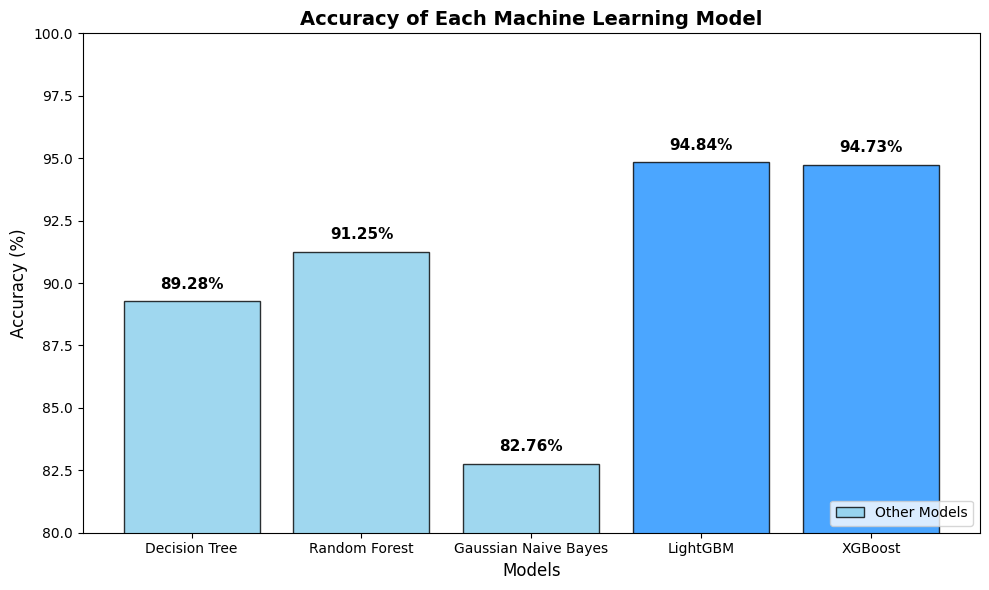

In [83]:
models = ['Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'LightGBM', 'XGBoost']
accuracy = [89.28, 91.25, 82.76, 94.84, 94.73]

plt.figure(figsize=(10, 6))
bar_colors = ['skyblue', 'skyblue', 'skyblue', 'dodgerblue', 'dodgerblue']  
plt.bar(models, accuracy, color=bar_colors, edgecolor='black', alpha=0.8)

plt.title('Accuracy of Each Machine Learning Model', fontsize=14, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(80, 100)  
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center', fontsize=11, fontweight='bold')

plt.legend(['Other Models', 'LightGBM & XGBoost'], loc='lower right')
plt.tight_layout()
plt.show()

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


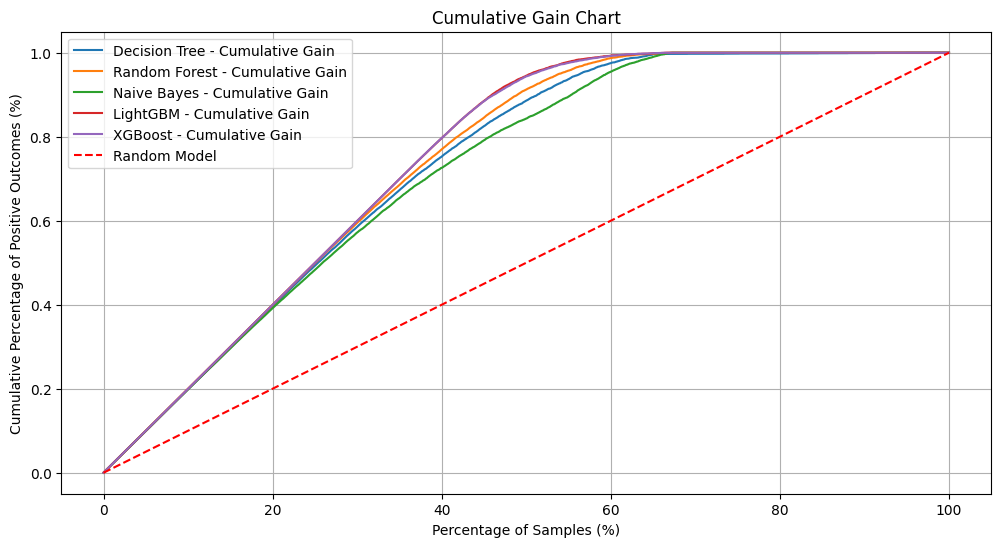

In [86]:
models = {
    'Decision Tree': dt_model,  # Decision Tree model
    'Random Forest': rf_model,  # Tuned Random Forest model
    'Naive Bayes': nb_model,    # Naive Bayes model
    'LightGBM': lgb_model,      # LightGBM model
    'XGBoost' : xgb_model       # XGBoost model
}


# Cumulative Gain Chart for all models
plt.figure(figsize=(12, 6))

for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = np.array(y_test)[sorted_indices]
    cumulative_gain = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    plt.plot(np.linspace(0, 100, len(y_true_sorted)), cumulative_gain, label=f'{model_name} - Cumulative Gain')

plt.plot([0, 100], [0, 1], linestyle='--', color='r', label="Random Model")
plt.title('Cumulative Gain Chart')
plt.xlabel('Percentage of Samples (%)')
plt.ylabel('Cumulative Percentage of Positive Outcomes (%)')
plt.legend()
plt.grid(True)
plt.show()


In [87]:
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = np.array(y_test)[sorted_indices]
    cumulative_gain = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    
    print(f"Cumulative Gain for {model_name}:")
    
    for i in range(0, len(y_true_sorted), len(y_true_sorted) // 10):  
        percentage = (i / len(y_true_sorted)) * 100
        gain = cumulative_gain[i]
        print(f"  {percentage:.1f}%: {gain:.4f}")
    
    print("\n" + "-"*40)  

print("Cumulative Gain for Random Model (Random Guess):")
for i in range(0, 101, 10):
    print(f"  {i:.1f}%: {i / 100:.4f}")


Cumulative Gain for Decision Tree:
  0.0%: 0.0002
  10.0%: 0.1986
  20.0%: 0.3961
  30.0%: 0.5854
  40.0%: 0.7526
  50.0%: 0.8859
  60.0%: 0.9751
  70.0%: 0.9975
  80.0%: 0.9981
  90.0%: 0.9991
  100.0%: 1.0000

----------------------------------------
Cumulative Gain for Random Forest:
  0.0%: 0.0002
  10.0%: 0.2000
  20.0%: 0.3997
  30.0%: 0.5950
  40.0%: 0.7699
  50.0%: 0.9124
  60.0%: 0.9871
  70.0%: 1.0000
  80.0%: 1.0000
  90.0%: 1.0000
  100.0%: 1.0000

----------------------------------------
Cumulative Gain for Naive Bayes:
  0.0%: 0.0002
  10.0%: 0.1986
  20.0%: 0.3918
  30.0%: 0.5720
  40.0%: 0.7260
  50.0%: 0.8431
  60.0%: 0.9548
  70.0%: 1.0000
  80.0%: 1.0000
  90.0%: 1.0000
  100.0%: 1.0000

----------------------------------------
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_lea

#### Chosen Model is LightGBM to predict loan status

#### -----------------------------------THIS NOTEBOOK ENDS HERE-----------------------------------